In [1]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MultipleLocator
from itertools import cycle
from math import pi
from json import loads, dumps

import ast

%config Completer.use_jedi = False


# 1. Read Data

In [2]:
# read data

folder_name = os.path.abspath(os.path.abspath(''))

dataset_path = "results/simple"
result_file = "results_all_optimised.csv"


filepath = os.path.join(folder_name, f"{dataset_path}/{result_file}")
dataframe = pd.read_csv(filepath, header=0)
dataframe


# arda = pd.read_csv(os.path.join(folder_name, f"{dataset_path}/results_arda.csv"), header=0)



,algorithm,data_path,approach,data_label,join_time,total_time,feature_selection_time,depth,accuracy,train_time,feature_importance,join_path_features,cutoff_threshold,redundancy_threshold,rank
0,LightGBM,credit/table8.csv--credit_amount-credit/table0...,ARDA,credit,NaN,5.301898,2.100083,NaN,0.705000,3.201816,{'credit/table8.csv.credit_amount': 0.01999999...,"['credit/table8.csv.age', 'credit/table8.csv.c...",NaN,NaN,NaN
1,RandomForest,credit/table8.csv--credit_amount-credit/table0...,ARDA,credit,NaN,5.301898,2.100083,NaN,0.640000,3.201816,{'credit/table8.csv.credit_amount': 0.05300000...,"['credit/table8.csv.age', 'credit/table8.csv.c...",NaN,NaN,NaN
2,ExtraTrees,credit/table8.csv--credit_amount-credit/table0...,ARDA,credit,NaN,5.301898,2.100083,NaN,0.620000,3.201816,{'credit/table8.csv.credit_amount': 0.02600000...,"['credit/table8.csv.age', 'credit/table8.csv.c...",NaN,NaN,NaN
3,XGBoost,credit/table8.csv--credit_amount-credit/table0...,ARDA,credit,NaN,5.301898,2.100083,NaN,0.670000,3.201816,{'credit/table8.csv.credit_amount': 0.03400000...,"['credit/table8.csv.age', 'credit/table8.csv.c...",NaN,NaN,NaN
4,LightGBM,steel/table_0_0.csv--Key_0_0-steel/table_1_3.c...,ARDA,steel,NaN,16.847417,12.880748,NaN,0.712082,3.966669,{'steel/table_1_3.csv.V20': 0.0488431876606684...,"['steel/table_1_3.csv.Key_1_3', 'steel/table_1...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,RandomForest,NaN,ALL,superconduct,NaN,NaN,NaN,NaN,9.054958,0.000000,{'range_ThermalConductivity': 24.4834592188917...,"['mean_atomic_mass', 'wtd_mean_atomic_mass', '...",NaN,NaN,NaN
260,ExtraTrees,NaN,ALL,yprop,NaN,NaN,NaN,NaN,0.027248,0.000000,"{'oz251': 0.006304777501749882, 'oz151': 0.005...","['oz1', 'oz2', 'oz3', 'oz4', 'oz5', 'oz6', 'oz...",NaN,NaN,NaN
261,XGBoost,NaN,ALL,yprop,NaN,NaN,NaN,NaN,0.027623,0.000000,"{'oz250': 0.006286416311748142, 'oz249': 0.002...","['oz1', 'oz2', 'oz3', 'oz4', 'oz5', 'oz6', 'oz...",NaN,NaN,NaN
262,LightGBM,NaN,ALL,yprop,NaN,NaN,NaN,NaN,0.027537,0.000000,"{'oz251': 0.0020598349479192075, 'oz250': 0.00...","['oz1', 'oz2', 'oz3', 'oz4', 'oz5', 'oz6', 'oz...",NaN,NaN,NaN


# Components analysis

In [14]:
tfd_acc = dataframe.groupby(['data_label', 'approach', 'algorithm', 'feature_selection_time'])[['accuracy']].max().reset_index()
arda_acc = arda.groupby(['data_label', 'approach', 'algorithm', 'feature_selection_time'])[['accuracy']].max().reset_index()


display(tfd_acc)
display(arda_acc)

,data_label,approach,algorithm,feature_selection_time,accuracy
0,air,TFD_BFS,ExtraTrees,1771.208232,0.862348
1,air,TFD_BFS,LightGBM,1771.208232,0.702209
2,air,TFD_BFS,RandomForest,1771.208232,0.837241
3,air,TFD_BFS,XGBoost,1771.208232,0.714772
4,bioresponse,TFD_BFS,ExtraTrees,1466.079366,0.774381
5,bioresponse,TFD_BFS,LightGBM,1466.079366,0.771470
6,bioresponse,TFD_BFS,RandomForest,1466.079366,0.780204
7,bioresponse,TFD_BFS,XGBoost,1466.079366,0.777293
8,covertype,TFD_BFS,ExtraTrees,2129.779043,0.908799
9,covertype,TFD_BFS,LightGBM,2129.779043,0.973695


,data_label,approach,algorithm,feature_selection_time,accuracy
0,air,ARDA,ExtraTrees,545.314306,0.956255
1,air,ARDA,LightGBM,545.314306,0.897292
2,air,ARDA,RandomForest,545.314306,0.933207
3,air,ARDA,XGBoost,545.314306,0.854443
4,bioresponse,ARDA,ExtraTrees,61.985190,0.626667
5,bioresponse,ARDA,LightGBM,61.985190,0.628333
6,bioresponse,ARDA,RandomForest,61.985190,0.631667
7,bioresponse,ARDA,XGBoost,61.985190,0.620000
8,covertype,ARDA,ExtraTrees,108.049190,0.498333
9,covertype,ARDA,LightGBM,108.049190,0.506667


# 2. Process data

## Remove unused columns

In [3]:
dataframe.drop(columns=['join_time', 'depth', 'redundancy_threshold', 'rank'], inplace=True)
dataframe

,algorithm,data_path,approach,data_label,total_time,feature_selection_time,accuracy,train_time,feature_importance,join_path_features,cutoff_threshold
0,LightGBM,credit/table8.csv--credit_amount-credit/table0...,ARDA,credit,5.301898,2.100083,0.705000,3.201816,{'credit/table8.csv.credit_amount': 0.01999999...,"['credit/table8.csv.age', 'credit/table8.csv.c...",NaN
1,RandomForest,credit/table8.csv--credit_amount-credit/table0...,ARDA,credit,5.301898,2.100083,0.640000,3.201816,{'credit/table8.csv.credit_amount': 0.05300000...,"['credit/table8.csv.age', 'credit/table8.csv.c...",NaN
2,ExtraTrees,credit/table8.csv--credit_amount-credit/table0...,ARDA,credit,5.301898,2.100083,0.620000,3.201816,{'credit/table8.csv.credit_amount': 0.02600000...,"['credit/table8.csv.age', 'credit/table8.csv.c...",NaN
3,XGBoost,credit/table8.csv--credit_amount-credit/table0...,ARDA,credit,5.301898,2.100083,0.670000,3.201816,{'credit/table8.csv.credit_amount': 0.03400000...,"['credit/table8.csv.age', 'credit/table8.csv.c...",NaN
4,LightGBM,steel/table_0_0.csv--Key_0_0-steel/table_1_3.c...,ARDA,steel,16.847417,12.880748,0.712082,3.966669,{'steel/table_1_3.csv.V20': 0.0488431876606684...,"['steel/table_1_3.csv.Key_1_3', 'steel/table_1...",NaN
...,...,...,...,...,...,...,...,...,...,...,...
259,RandomForest,NaN,ALL,superconduct,NaN,NaN,9.054958,0.000000,{'range_ThermalConductivity': 24.4834592188917...,"['mean_atomic_mass', 'wtd_mean_atomic_mass', '...",NaN
260,ExtraTrees,NaN,ALL,yprop,NaN,NaN,0.027248,0.000000,"{'oz251': 0.006304777501749882, 'oz151': 0.005...","['oz1', 'oz2', 'oz3', 'oz4', 'oz5', 'oz6', 'oz...",NaN
261,XGBoost,NaN,ALL,yprop,NaN,NaN,0.027623,0.000000,"{'oz250': 0.006286416311748142, 'oz249': 0.002...","['oz1', 'oz2', 'oz3', 'oz4', 'oz5', 'oz6', 'oz...",NaN
262,LightGBM,NaN,ALL,yprop,NaN,NaN,0.027537,0.000000,"{'oz251': 0.0020598349479192075, 'oz250': 0.00...","['oz1', 'oz2', 'oz3', 'oz4', 'oz5', 'oz6', 'oz...",NaN


## Process columns

In [4]:
def parse_feature_importance(dataframe):

    result = dataframe['feature_importance'].fillna('{}')

    number_of_features = []
    features = []
    for i in result:
        j = i.replace("\'", "\"")
        js = loads(j)
        number_of_features.append(len(js.values()))
        features.append(list(js.keys()))

#     print(number_of_features)
    return number_of_features, features


In [5]:
def parse_join_path_features(dataframe):
    dataframe['join_path_features'] = dataframe['join_path_features'].fillna('')
    result = dataframe['join_path_features']

    number_of_features = []
    jp_features = []
    for i in result:
        j = i.replace("[", "")
        j = j.replace("]", "")
        j = j.replace("'", "")
        k = j.split(", ")
    #     print(k)
    #     print(len(k))

        if len(k) == 1:
            number_of_features.append(0)
        else:
            number_of_features.append(len(k))
        jp_features.append(k)

#     print(number_of_features)
    # print(jp_features)
    return number_of_features, jp_features
    

In [6]:
def determine_common_features(dataframe):

    nr_common_features = []
    difference = []

    for i, values in enumerate(features):
        set_a = set(values)
        set_b = set(jp_features[i])

#         print(set_a)
#         print(set_b)
    #     print(len(set_a.intersection(set_b)))

        nr_common_features.append(len(set_a.intersection(set_b)))
        difference.append(set_b - set_a)

    # print(nr_common_features)
    # print(difference)
    return nr_common_features, difference


In [7]:
number_of_features, features = parse_feature_importance(dataframe)
dataframe['number_features_importance'] = number_of_features

number_of_features, jp_features = parse_join_path_features(dataframe)
dataframe['number_join_path_features'] = number_of_features

nr_common_features, difference = determine_common_features(dataframe)
dataframe['nr_common_features'] = nr_common_features
dataframe['different_features'] = difference

dataframe

JSONDecodeError: Expecting ':' delimiter: line 1 column 2924 (char 2923)

In [8]:
res = dataframe.loc[dataframe['number_features_importance'] != dataframe["number_join_path_features"]]

res
# print(res['feature_importance'])
# print(res['join_path_features'])


,algorithm,data_path,approach,data_label,total_time,feature_selection_time,accuracy,train_time,feature_importance,join_path_features,cutoff_threshold,number_features_importance,number_join_path_features,nr_common_features,different_features
16,LightGBM,covertype/table_0_0.csv--Key_0_0-covertype/tab...,ARDA,covertype,112.669787,108.049190,0.506667,4.620597,{'covertype/table_1_1.csv.Key_1_1': 0.00300000...,"['covertype/table_1_3.csv.Key_1_3', 'covertype...",NaN,6,7,6,{covertype/table_0_0.csv.Soil_Type36}
17,RandomForest,covertype/table_0_0.csv--Key_0_0-covertype/tab...,ARDA,covertype,112.669787,108.049190,0.500000,4.620597,{'covertype/table_0_0.csv.Soil_Type33': 0.0109...,"['covertype/table_1_3.csv.Key_1_3', 'covertype...",NaN,6,7,6,{covertype/table_0_0.csv.Soil_Type36}
18,ExtraTrees,covertype/table_0_0.csv--Key_0_0-covertype/tab...,ARDA,covertype,112.669787,108.049190,0.498333,4.620597,{'covertype/table_0_0.csv.Soil_Type33': 0.0146...,"['covertype/table_1_3.csv.Key_1_3', 'covertype...",NaN,6,7,6,{covertype/table_0_0.csv.Soil_Type36}
19,XGBoost,covertype/table_0_0.csv--Key_0_0-covertype/tab...,ARDA,covertype,112.669787,108.049190,0.521667,4.620597,{'covertype/table_1_3.csv.Key_1_3': 0.01066666...,"['covertype/table_1_3.csv.Key_1_3', 'covertype...",NaN,6,7,6,{covertype/table_0_0.csv.Soil_Type36}
28,LightGBM,school/base.csv--DBN-school/yabc.csv--DBN-scho...,ARDA,school,247.163424,231.340281,0.819718,15.823142,{'school/Schools_Progress_Report_2012-2013.csv...,['school/2010_Gen_Ed_Survey_Data.csv.eng_t_10'...,NaN,56,57,56,{school/base.csv.DBN}
29,RandomForest,school/base.csv--DBN-school/yabc.csv--DBN-scho...,ARDA,school,247.163424,231.340281,0.802817,15.823142,{'school/Schools_Progress_Report_2012-2013.csv...,['school/2010_Gen_Ed_Survey_Data.csv.eng_t_10'...,NaN,56,57,56,{school/base.csv.DBN}
30,ExtraTrees,school/base.csv--DBN-school/yabc.csv--DBN-scho...,ARDA,school,247.163424,231.340281,0.791549,15.823142,{'school/Schools_Progress_Report_2012-2013.csv...,['school/2010_Gen_Ed_Survey_Data.csv.eng_t_10'...,NaN,56,57,56,{school/base.csv.DBN}
31,XGBoost,school/base.csv--DBN-school/yabc.csv--DBN-scho...,ARDA,school,247.163424,231.340281,0.788732,15.823142,{'school/Schools_Progress_Report_2012-2013.csv...,['school/2010_Gen_Ed_Survey_Data.csv.eng_t_10'...,NaN,56,57,56,{school/base.csv.DBN}
72,LightGBM,school,BASE,school,0.000000,NaN,0.718310,NaN,"{'School Type': 0.09070422535211271, 'Total Pa...","['DBN', 'School Name', 'School Type', 'Total P...",NaN,5,6,5,{DBN}
73,RandomForest,school,BASE,school,0.000000,NaN,0.707042,NaN,{'Total Parent Response Rate (%)': 0.071549295...,"['DBN', 'School Name', 'School Type', 'Total P...",NaN,5,6,5,{DBN}


# 3. Get global variables

In [8]:
# get global variables 

algs = list(dataframe['algorithm'].unique())
print(algs)

tables = list(dataframe['data_label'].unique())
print(tables)

approach = list(dataframe['approach'].unique())
print(approach)


['LightGBM', 'RandomForest', 'ExtraTrees', 'XGBoost']
['credit', 'steel', 'jannis', 'miniboone', 'covertype', 'eyemove', 'bioresponse', 'school', 'air', 'yprop', 'superconduct']
['ARDA', 'BASE', 'MAB', 'TFD_BFS', 'ALL']


# Path processing

In [25]:
covertype_lgb_tfd = dataframe[(dataframe['approach'].isin(['TFD_BFS', 'ARDA'])) & (dataframe['data_label'].isin(['covertype'])) & (dataframe['algorithm'] == 'LightGBM')]

display(covertype_lgb_tfd)

data_path = list(covertype_lgb_tfd['data_path'])

print(data_path)
print(f"\n {selected_features}")



,algorithm,data_path,approach,data_label,total_time,feature_selection_time,accuracy,train_time,feature_importance,join_path_features,cutoff_threshold,number_features_importance,number_join_path_features,nr_common_features,different_features
16,LightGBM,covertype/table_0_0.csv--Key_0_0-covertype/tab...,ARDA,covertype,112.669787,108.049190,0.506667,4.620597,{'covertype/table_1_1.csv.Key_1_1': 0.00300000...,"['covertype/table_1_3.csv.Key_1_3', 'covertype...",NaN,6,7,6,{covertype/table_0_0.csv.Soil_Type36}
124,LightGBM,covertype/table_0_0.csv--Key_0_0-covertype/tab...,TFD_BFS,covertype,2220.120259,2129.779043,0.621849,90.341216,{'covertype/table_1_2.csv.Aspect': 0.060399999...,"['covertype/table_0_0.csv.Soil_Type32', 'cover...",0.65,15,15,15,{}
128,LightGBM,covertype/table_0_0.csv--Key_0_0-covertype/tab...,TFD_BFS,covertype,3046.776437,2129.779043,0.973695,916.997394,{'covertype/table_2_12.csv.Elevation': 0.31792...,"['covertype/table_2_9.csv.Soil_Type30', 'cover...",0.65,47,47,47,{}


['covertype/table_0_0.csv--Key_0_0-covertype/table_1_3.csv--Key_0_0-covertype/table_1_2.csv--Key_0_0-covertype/table_1_1.csv', 'covertype/table_0_0.csv--Key_0_0-covertype/table_1_1.csv--Key_0_0-covertype/table_1_2.csv--Key_0_0-covertype/table_1_3.csv', 'covertype/table_0_0.csv--Key_0_0-covertype/table_1_1.csv--Key_0_0-covertype/table_1_2.csv--Key_0_0-covertype/table_1_3.csv--Key_1_1-covertype/table_2_4.csv--Key_1_1-covertype/table_2_5.csv--Key_1_1-covertype/table_2_6.csv--Key_1_3-covertype/table_2_10.csv--Key_1_3-covertype/table_2_11.csv--Key_1_3-covertype/table_2_12.csv--Key_1_2-covertype/table_2_7.csv--Key_1_2-covertype/table_2_8.csv--Key_1_2-covertype/table_2_9.csv']

 ["['covertype/table_1_3.csv.Key_1_3', 'covertype/table_1_1.csv.Key_1_1', 'covertype/table_0_0.csv.Soil_Type20', 'covertype/table_0_0.csv.Soil_Type36', 'covertype/table_0_0.csv.Soil_Type32', 'covertype/table_0_0.csv.Soil_Type33', 'covertype/table_0_0.csv.Key_0_0']", "['covertype/table_0_0.csv.Soil_Type32', 'covertype/t

In [24]:
path_length = {}
for path in data_path:
    path_length[path] = len(path.split("--"))
    
path_length  

{'covertype/table_0_0.csv--Key_0_0-covertype/table_1_3.csv--Key_0_0-covertype/table_1_2.csv--Key_0_0-covertype/table_1_1.csv': 4,
 'covertype/table_0_0.csv--Key_0_0-covertype/table_1_1.csv--Key_0_0-covertype/table_1_2.csv--Key_0_0-covertype/table_1_3.csv': 4,
 'covertype/table_0_0.csv--Key_0_0-covertype/table_1_1.csv--Key_0_0-covertype/table_1_2.csv--Key_0_0-covertype/table_1_3.csv--Key_1_1-covertype/table_2_4.csv--Key_1_1-covertype/table_2_5.csv--Key_1_1-covertype/table_2_6.csv--Key_1_3-covertype/table_2_10.csv--Key_1_3-covertype/table_2_11.csv--Key_1_3-covertype/table_2_12.csv--Key_1_2-covertype/table_2_7.csv--Key_1_2-covertype/table_2_8.csv--Key_1_2-covertype/table_2_9.csv': 13}

In [47]:
selected_features = list(covertype_lgb_tfd['join_path_features'])
selected_features = [el.replace("\'", "").strip("][").split(', ') for el in selected_features]
# selected_features

print(set(selected_features[0]).intersection(set(selected_features[1])))
print(set(selected_features[0]) - (set(selected_features[1])))
print(set(selected_features[1]) - (set(selected_features[0])))



{'covertype/table_0_0.csv.Soil_Type20', 'covertype/table_0_0.csv.Soil_Type36', 'covertype/table_0_0.csv.Soil_Type32', 'covertype/table_0_0.csv.Soil_Type33'}
{'covertype/table_0_0.csv.Key_0_0', 'covertype/table_1_1.csv.Key_1_1', 'covertype/table_1_3.csv.Key_1_3'}
{'covertype/table_1_3.csv.Soil_Type17', 'covertype/table_1_3.csv.Soil_Type16', 'covertype/table_1_1.csv.Hillshade_3pm', 'covertype/table_1_3.csv.Soil_Type31', 'covertype/table_1_3.csv.Wilderness_Area3', 'covertype/table_1_2.csv.Wilderness_Area1', 'covertype/table_1_2.csv.Aspect', 'covertype/table_1_2.csv.Soil_Type27', 'covertype/table_1_1.csv.Soil_Type7', 'covertype/table_1_1.csv.Soil_Type25', 'covertype/table_1_2.csv.Horizontal_Distance_To_Hydrology'}



# 4. Create datasets for plots

## Accuracy

In [9]:
accuracy = dataframe.groupby(['data_label', 'approach', 'algorithm'])[['accuracy']].max().reset_index()

        
# accuracy_data = data.groupby(['data_label', 'approach', 'algorithm'])[['accuracy']].max().reset_index()

display(accuracy)
    

,data_label,approach,algorithm,accuracy
0,air,ARDA,ExtraTrees,0.956255
1,air,ARDA,LightGBM,0.897292
2,air,ARDA,RandomForest,0.933207
3,air,ARDA,XGBoost,0.854443
4,air,BASE,ExtraTrees,0.892137
...,...,...,...,...
207,yprop,MAB,XGBoost,0.028797
208,yprop,TFD_BFS,ExtraTrees,0.029148
209,yprop,TFD_BFS,LightGBM,0.028597
210,yprop,TFD_BFS,RandomForest,0.029279


## Total time

In [10]:


total_time = dataframe.groupby(['data_label', 'approach', 'algorithm'])[['accuracy', 'total_time']].max().reset_index()
        
total_time['total_time'] = total_time['total_time'].apply(np.log10)
display(total_time)
    

,data_label,approach,algorithm,accuracy,total_time
0,air,ARDA,ExtraTrees,0.956255,2.741797
1,air,ARDA,LightGBM,0.897292,2.741797
2,air,ARDA,RandomForest,0.933207,2.741797
3,air,ARDA,XGBoost,0.854443,2.741797
4,air,BASE,ExtraTrees,0.892137,-inf
...,...,...,...,...,...
207,yprop,MAB,XGBoost,0.028797,1.225309
208,yprop,TFD_BFS,ExtraTrees,0.029148,0.837578
209,yprop,TFD_BFS,LightGBM,0.028597,0.837578
210,yprop,TFD_BFS,RandomForest,0.029279,0.837578


In [68]:
folder_name = os.path.abspath(os.path.abspath(''))

dataset_path = "results/"
result_file = "jannis-eyemove.csv"


filepath = os.path.join(folder_name, f"{dataset_path}/{result_file}")
data = pd.read_csv(filepath, header=0)
data

,algorithm,data_path,approach,data_label,join_time,total_time,feature_selection_time,depth,accuracy,train_time,feature_importance,join_path_features,cutoff_threshold,redundancy_threshold,rank
0,LightGBM,table_0_0.csv--Key_0_0-table_1_3.csv--Key_0_0-...,ARDA,eyemove,NaN,41.854198,41.854198,NaN,0.490000,NaN,{'table_1_1.csv.Key_1_1': 0.006666666666666654...,"['table_1_1.csv.Key_1_1', 'table_1_3.csv.Key_1...",NaN,NaN,NaN
1,RandomForest,table_0_0.csv--Key_0_0-table_1_3.csv--Key_0_0-...,ARDA,eyemove,NaN,41.854198,41.854198,NaN,0.491667,NaN,{'table_1_3.csv.pupilDiamMax': 0.0086666666666...,"['table_1_1.csv.Key_1_1', 'table_1_3.csv.Key_1...",NaN,NaN,NaN
2,ExtraTrees,table_0_0.csv--Key_0_0-table_1_3.csv--Key_0_0-...,ARDA,eyemove,NaN,41.854198,41.854198,NaN,0.476667,NaN,{'table_1_3.csv.pupilDiamMax': -0.009333333333...,"['table_1_1.csv.Key_1_1', 'table_1_3.csv.Key_1...",NaN,NaN,NaN
3,XGBoost,table_0_0.csv--Key_0_0-table_1_3.csv--Key_0_0-...,ARDA,eyemove,NaN,41.854198,41.854198,NaN,0.496667,NaN,{'table_1_3.csv.pupilDiamMax': 0.0156666666666...,"['table_1_1.csv.Key_1_1', 'table_1_3.csv.Key_1...",NaN,NaN,NaN
4,LightGBM,eyemove,BASE,eyemove,NaN,0.000000,NaN,NaN,0.516426,NaN,"{'meanFixDur': 0.013929040735873833, 'timePrtc...","['meanFixDur', 'timePrtctg', 'firstfixDur']",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,XGBoost,table_0_0.csv--Key_0_0-table_1_2.csv--Key_0_0-...,TFD_BFS,jannis,NaN,4322.495302,4322.495302,NaN,0.755297,NaN,"{'table_2_11.csv.V20': 0.06360000000000003, 't...","['table_2_11.csv.V20', 'table_1_2.csv.V40', 't...",0.65,NaN,NaN
92,LightGBM,table_0_0.csv--Key_0_0-table_1_1.csv--Key_0_0-...,TFD_BFS,jannis,NaN,4322.495302,4322.495302,NaN,0.718479,NaN,"{'table_2_12.csv.V6': 0.10003999999999999, 'ta...","['table_1_1.csv.V35', 'table_2_12.csv.V13', 't...",0.65,NaN,NaN
93,RandomForest,table_0_0.csv--Key_0_0-table_1_1.csv--Key_0_0-...,TFD_BFS,jannis,NaN,4322.495302,4322.495302,NaN,0.715092,NaN,"{'table_2_12.csv.V6': 0.093, 'table_2_12.csv.V...","['table_1_1.csv.V35', 'table_2_12.csv.V13', 't...",0.65,NaN,NaN
94,ExtraTrees,table_0_0.csv--Key_0_0-table_1_1.csv--Key_0_0-...,TFD_BFS,jannis,NaN,4322.495302,4322.495302,NaN,0.708406,NaN,"{'table_2_12.csv.V6': 0.08312000000000001, 'ta...","['table_1_1.csv.V35', 'table_2_12.csv.V13', 't...",0.65,NaN,NaN


In [70]:
data[(data['data_label'] == 'jannis') & (data['approach'] == 'TFD_BFS')]

,algorithm,data_path,approach,data_label,join_time,total_time,feature_selection_time,depth,accuracy,train_time,feature_importance,join_path_features,cutoff_threshold,redundancy_threshold,rank
56,LightGBM,table_0_0.csv--Key_0_0-table_1_1.csv--Key_0_0-...,TFD_BFS,jannis,NaN,4322.495302,4322.495302,NaN,0.780566,NaN,"{'table_2_12.csv.V6': 0.06324, 'table_2_11.csv...","['table_2_11.csv.V20', 'table_1_1.csv.V35', 't...",0.65,NaN,NaN
57,RandomForest,table_0_0.csv--Key_0_0-table_1_1.csv--Key_0_0-...,TFD_BFS,jannis,NaN,4322.495302,4322.495302,NaN,0.776659,NaN,"{'table_2_11.csv.V20': 0.052879999999999996, '...","['table_2_11.csv.V20', 'table_1_1.csv.V35', 't...",0.65,NaN,NaN
58,ExtraTrees,table_0_0.csv--Key_0_0-table_1_1.csv--Key_0_0-...,TFD_BFS,jannis,NaN,4322.495302,4322.495302,NaN,0.767367,NaN,"{'table_2_12.csv.V6': 0.04511999999999998, 'ta...","['table_2_11.csv.V20', 'table_1_1.csv.V35', 't...",0.65,NaN,NaN
59,XGBoost,table_0_0.csv--Key_0_0-table_1_1.csv--Key_0_0-...,TFD_BFS,jannis,NaN,4322.495302,4322.495302,NaN,0.778829,NaN,"{'table_2_12.csv.V6': 0.061160000000000034, 't...","['table_2_11.csv.V20', 'table_1_1.csv.V35', 't...",0.65,NaN,NaN
60,LightGBM,table_0_0.csv--Key_0_0-table_1_2.csv--Key_0_0-...,TFD_BFS,jannis,NaN,4322.495302,4322.495302,NaN,0.759552,NaN,"{'table_2_12.csv.V6': 0.07768, 'table_2_11.csv...","['table_2_12.csv.V13', 'table_1_2.csv.V40', 't...",0.65,NaN,NaN
61,RandomForest,table_0_0.csv--Key_0_0-table_1_2.csv--Key_0_0-...,TFD_BFS,jannis,NaN,4322.495302,4322.495302,NaN,0.759639,NaN,"{'table_2_12.csv.V6': 0.055559999999999984, 't...","['table_2_12.csv.V13', 'table_1_2.csv.V40', 't...",0.65,NaN,NaN
62,ExtraTrees,table_0_0.csv--Key_0_0-table_1_2.csv--Key_0_0-...,TFD_BFS,jannis,NaN,4322.495302,4322.495302,NaN,0.747048,NaN,"{'table_2_12.csv.V6': 0.057559999999999986, 't...","['table_2_12.csv.V13', 'table_1_2.csv.V40', 't...",0.65,NaN,NaN
63,XGBoost,table_0_0.csv--Key_0_0-table_1_2.csv--Key_0_0-...,TFD_BFS,jannis,NaN,4322.495302,4322.495302,NaN,0.761462,NaN,"{'table_2_12.csv.V6': 0.08071999999999997, 'ta...","['table_2_12.csv.V13', 'table_1_2.csv.V40', 't...",0.65,NaN,NaN
64,LightGBM,table_0_0.csv--Key_0_0-table_1_2.csv--Key_0_0-...,TFD_BFS,jannis,NaN,4322.495302,4322.495302,NaN,0.769191,NaN,"{'table_2_12.csv.V6': 0.0686, 'table_2_11.csv....","['table_2_11.csv.V20', 'table_1_2.csv.V40', 't...",0.65,NaN,NaN
65,RandomForest,table_0_0.csv--Key_0_0-table_1_2.csv--Key_0_0-...,TFD_BFS,jannis,NaN,4322.495302,4322.495302,NaN,0.776485,NaN,"{'table_2_11.csv.V20': 0.06395999999999998, 't...","['table_2_11.csv.V20', 'table_1_2.csv.V40', 't...",0.65,NaN,NaN


In [71]:
dataframe[(dataframe['data_label'] == 'jannis') & (dataframe['approach'] == 'TFD_BFS')]

,algorithm,data_path,approach,data_label,total_time,feature_selection_time,accuracy,train_time,feature_importance,join_path_features,cutoff_threshold,number_features_importance,number_join_path_features,nr_common_features,different_features
53,LightGBM,table_0_0.csv--Key_0_0-table_1_2.csv--Key_0_0-...,TFD_BFS,jannis,3425.140637,3425.140637,0.732286,NaN,"{'table_0_0.csv.V22': 0.13052000000000002, 'ta...","['table_0_0.csv.V13', 'table_0_0.csv.V15', 'ta...",0.65,10,10,10,{}
54,RandomForest,table_0_0.csv--Key_0_0-table_1_2.csv--Key_0_0-...,TFD_BFS,jannis,3425.140637,3425.140637,0.737148,NaN,"{'table_0_0.csv.V22': 0.12332000000000001, 'ta...","['table_0_0.csv.V13', 'table_0_0.csv.V15', 'ta...",0.65,10,10,10,{}
55,ExtraTrees,table_0_0.csv--Key_0_0-table_1_2.csv--Key_0_0-...,TFD_BFS,jannis,3425.140637,3425.140637,0.739493,NaN,"{'table_0_0.csv.V22': 0.12716, 'table_0_0.csv....","['table_0_0.csv.V13', 'table_0_0.csv.V15', 'ta...",0.65,10,10,10,{}
56,XGBoost,table_0_0.csv--Key_0_0-table_1_2.csv--Key_0_0-...,TFD_BFS,jannis,3425.140637,3425.140637,0.733675,NaN,"{'table_0_0.csv.V22': 0.13000000000000003, 'ta...","['table_0_0.csv.V13', 'table_0_0.csv.V15', 'ta...",0.65,10,10,10,{}
57,LightGBM,table_0_0.csv--Key_0_0-table_1_1.csv--Key_0_0-...,TFD_BFS,jannis,3425.140637,3425.140637,0.743227,NaN,"{'table_0_0.csv.V22': 0.11388000000000002, 'ta...","['table_1_1.csv.V24', 'table_2_9.csv.V35', 'ta...",0.65,12,12,12,{}
58,RandomForest,table_0_0.csv--Key_0_0-table_1_1.csv--Key_0_0-...,TFD_BFS,jannis,3425.140637,3425.140637,0.750695,NaN,"{'table_0_0.csv.V22': 0.08839999999999996, 'ta...","['table_1_1.csv.V24', 'table_2_9.csv.V35', 'ta...",0.65,12,12,12,{}
59,ExtraTrees,table_0_0.csv--Key_0_0-table_1_1.csv--Key_0_0-...,TFD_BFS,jannis,3425.140637,3425.140637,0.748611,NaN,"{'table_0_0.csv.V22': 0.09071999999999998, 'ta...","['table_1_1.csv.V24', 'table_2_9.csv.V35', 'ta...",0.65,12,12,12,{}
60,XGBoost,table_0_0.csv--Key_0_0-table_1_1.csv--Key_0_0-...,TFD_BFS,jannis,3425.140637,3425.140637,0.740014,NaN,"{'table_0_0.csv.V22': 0.11039999999999998, 'ta...","['table_1_1.csv.V24', 'table_2_9.csv.V35', 'ta...",0.65,12,12,12,{}
61,LightGBM,table_0_0.csv--Key_0_0-table_1_1.csv--Key_0_0-...,TFD_BFS,jannis,3425.140637,3425.140637,0.743748,NaN,"{'table_0_0.csv.V22': 0.10628, 'table_1_1.csv....","['table_2_8.csv.V54', 'table_2_9.csv.V35', 'ta...",0.65,15,15,15,{}
62,RandomForest,table_0_0.csv--Key_0_0-table_1_1.csv--Key_0_0-...,TFD_BFS,jannis,3425.140637,3425.140637,0.746874,NaN,"{'table_0_0.csv.V22': 0.07188000000000001, 'ta...","['table_2_8.csv.V54', 'table_2_9.csv.V35', 'ta...",0.65,15,15,15,{}


## Compare number of features

In [87]:
feat_df = dataframe.groupby(['data_label', 'approach', 'algorithm'])[['accuracy', 'number_features_importance', 'number_join_path_features']].max().reset_index()

feat_df.drop(feat_df[feat_df['approach']=='BASE'].index, inplace=True)

feat_df

,data_label,approach,algorithm,accuracy,number_features_importance,number_join_path_features
0,air,ARDA,ExtraTrees,0.956255,13,13
1,air,ARDA,LightGBM,0.897292,13,13
2,air,ARDA,RandomForest,0.933207,13,13
3,air,ARDA,XGBoost,0.854443,13,13
8,air,MAB,ExtraTrees,0.927134,8,9
...,...,...,...,...,...,...
167,yprop,MAB,XGBoost,0.028797,20,21
168,yprop,TFD_BFS,ExtraTrees,0.029299,39,39
169,yprop,TFD_BFS,LightGBM,0.028033,39,39
170,yprop,TFD_BFS,RandomForest,0.029454,39,39


# 5. Plot data

## Accuracy one algorithm

,data_label,approach,algorithm,accuracy
0,jannis,ARDA,ExtraTrees,0.591667
1,jannis,ARDA,LightGBM,0.578333
2,jannis,ARDA,RandomForest,0.586667
3,jannis,ARDA,XGBoost,0.575000
4,jannis,BASE,ExtraTrees,0.557903


Text(0.5, 1.0, 'Accuracy for each approach for each dataset')

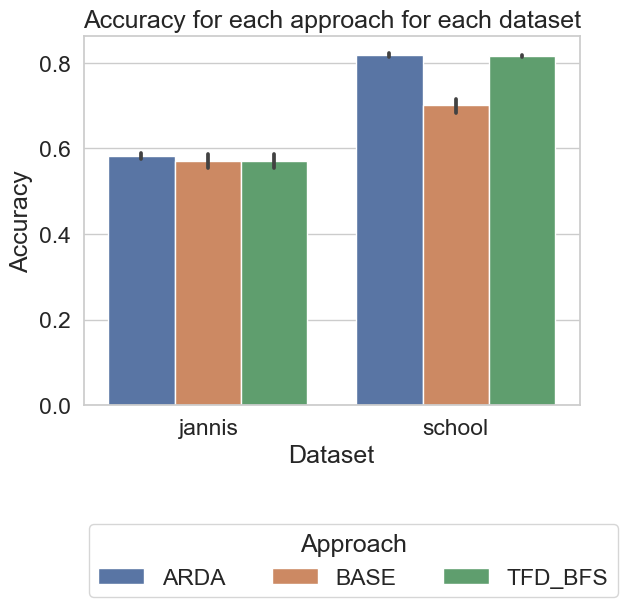

In [21]:

display(accuracy.head())

sns.set(font_scale=1.5, style="whitegrid")
colors = sns.color_palette("Set2")

ax = sns.barplot(data=accuracy, x="data_label", y="accuracy", hue="approach")

ax.set_xlabel('Dataset')
ax.set_ylabel('Accuracy')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

plt.legend(hh, ll, bbox_to_anchor=(1.1, -0.55), loc=4, ncol=3, title="Approach")
ax.set_title("Accuracy for each approach for each dataset")

# plt.savefig('plots/2024/accuracy_1.png', dpi=300, bbox_inches="tight")




In [46]:
# accuracy['data_label']

accuracy.drop(accuracy[accuracy['data_label'] == 'credit'].index, inplace=True)

display(accuracy)

,data_label,approach,algorithm,accuracy
0,bioresponse,ARDA,ExtraTrees,0.723333
1,bioresponse,ARDA,LightGBM,0.658333
2,bioresponse,ARDA,RandomForest,0.703333
3,bioresponse,ARDA,XGBoost,0.661667
4,bioresponse,BASE,ExtraTrees,0.711790
...,...,...,...,...
67,steel,BASE,XGBoost,0.712082
68,steel,TFD_BFS,ExtraTrees,0.807198
69,steel,TFD_BFS,LightGBM,0.794344
70,steel,TFD_BFS,RandomForest,0.807198


## Accuracy all algorithms

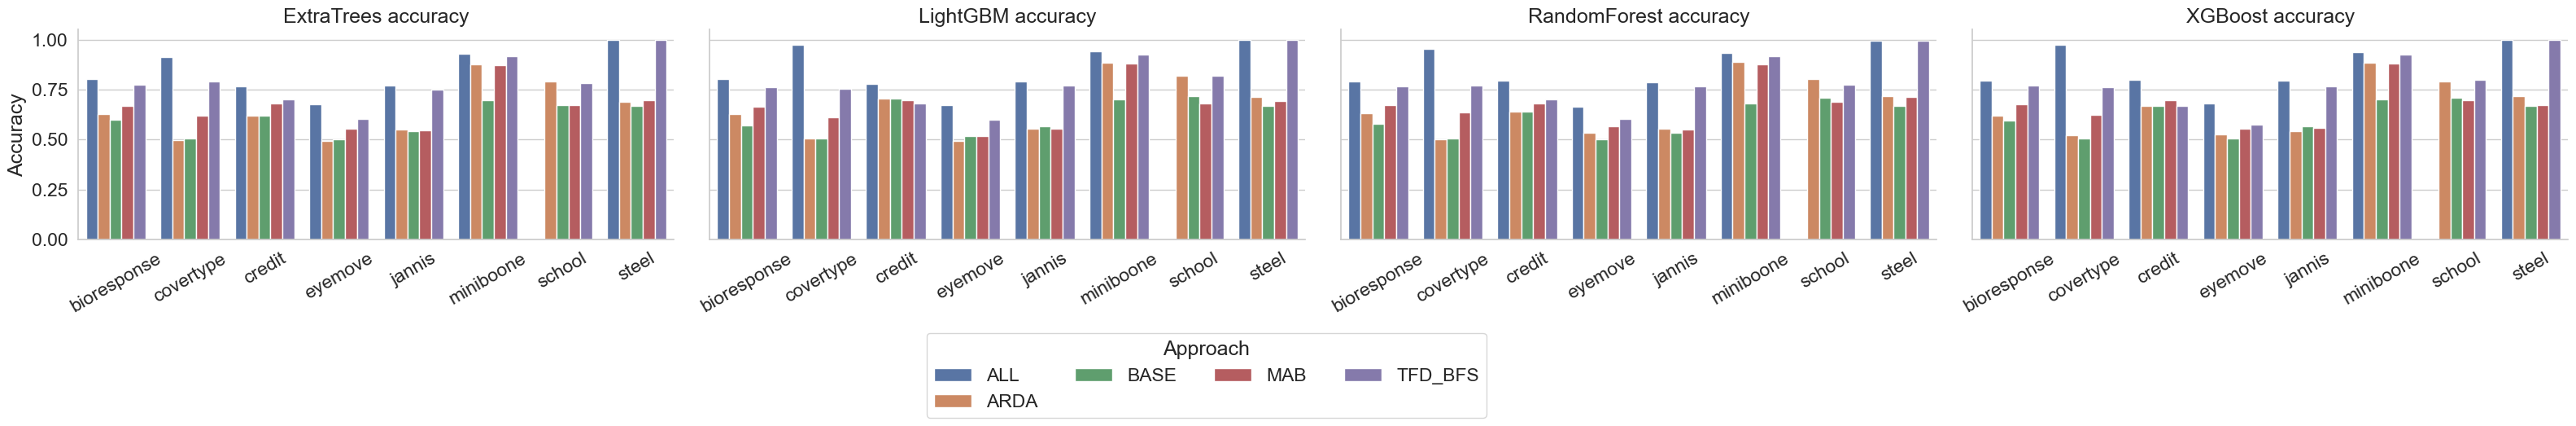

In [12]:
sns.set(font_scale=1.5, style="whitegrid")
# plt.subplots(figsize=(20, 4))

aux = accuracy[~accuracy['data_label'].isin(['air', 'superconduct', 'yprop'])]

g = sns.catplot(x="data_label", y="accuracy", hue="approach", col="algorithm", 
                data=aux, kind="bar", height=4, aspect=2)

g.set_titles("{col_name} accuracy")
g.set_xlabels('')
g.set_ylabels('Accuracy')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(-0.8, -0.4), ncol=4, title="Approach")
# 
g.savefig('plots/2024/accuracy_8_classification_optimised.png', dpi=300, bbox_inches="tight")


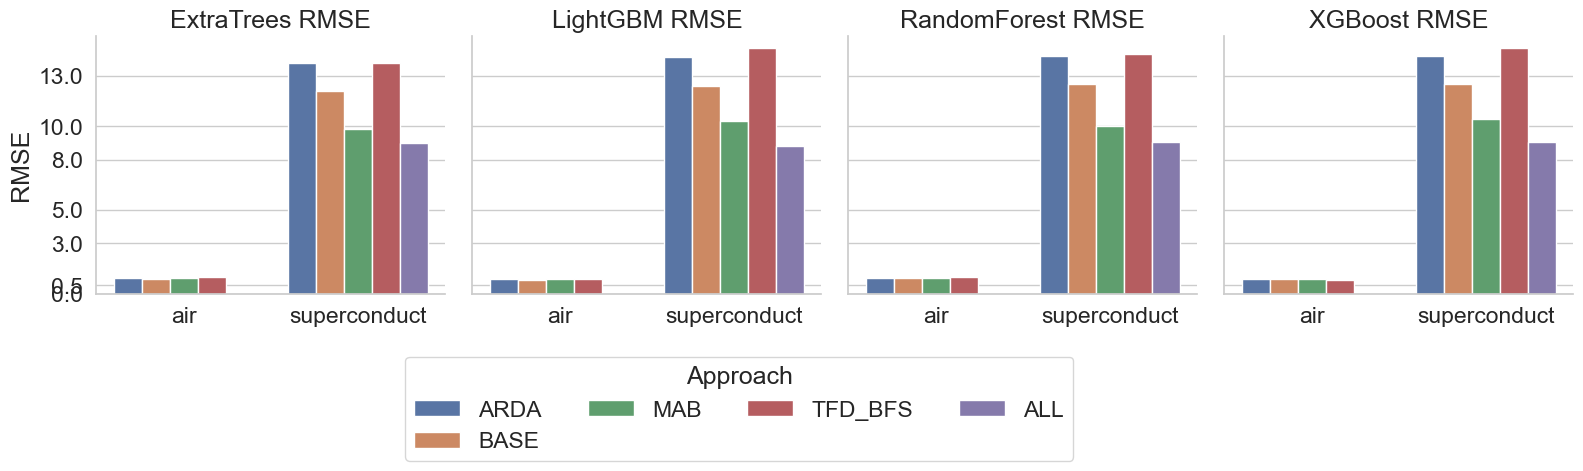

In [18]:
sns.set(font_scale=1.5, style="whitegrid")
# plt.subplots(figsize=(20, 4))

aux = accuracy[accuracy['data_label'].isin(['superconduct', 'air'])]

g = sns.catplot(x="data_label", y="accuracy", hue="approach", col="algorithm", 
                data=aux, kind="bar", height=4, aspect=1)

g.set_titles("{col_name} RMSE")
g.set_xlabels('')
g.set_ylabels('RMSE')
plt.yticks([0,0.5, 3, 5, 8, 10, 13])


loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(-0.4, -0.2), ncol=4, title="Approach")
# 
g.savefig('plots/2024/accuracy_2_regression_optimised.png', dpi=300, bbox_inches="tight")


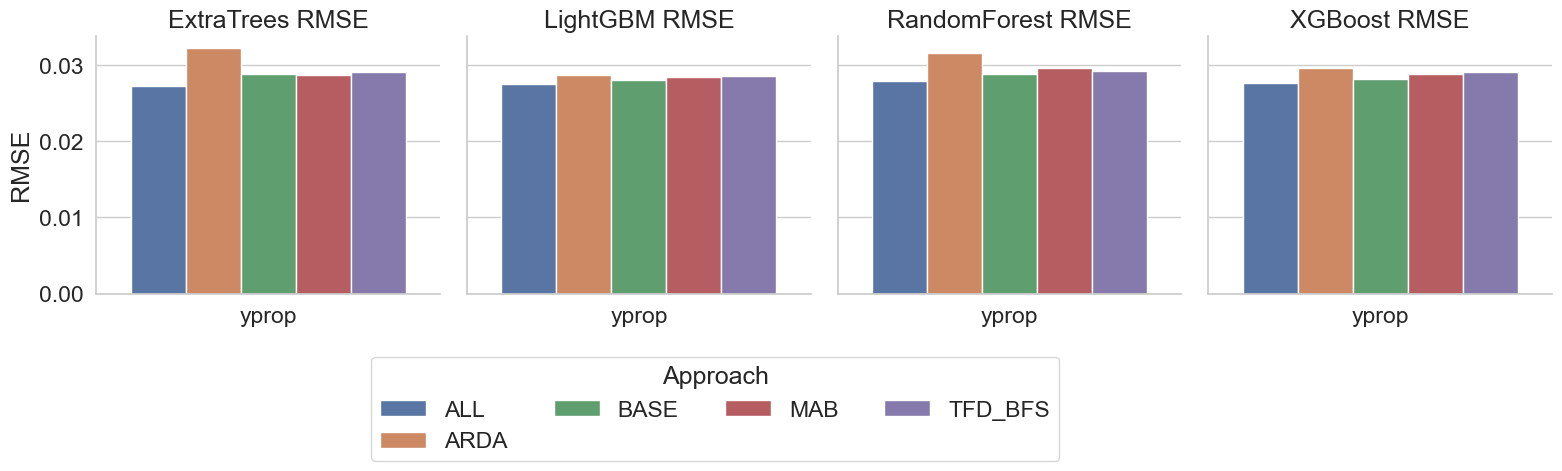

In [15]:
sns.set(font_scale=1.5, style="whitegrid")
# plt.subplots(figsize=(20, 4))

aux = accuracy[accuracy['data_label'].isin(['yprop'])]

g = sns.catplot(x="data_label", y="accuracy", hue="approach", col="algorithm", 
                data=aux, kind="bar", height=4, aspect=1)

g.set_titles("{col_name} RMSE")
g.set_xlabels('')
g.set_ylabels('RMSE')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(-0.4, -0.2), ncol=4, title="Approach")
# 
g.savefig('plots/2024/accuracy_yprop_optimised.png', dpi=300, bbox_inches="tight")


## Total time - one algorithm

,data_label,approach,algorithm,accuracy,total_time
0,bioresponse,ARDA,ExtraTrees,0.723333,2.077434
1,bioresponse,ARDA,LightGBM,0.658333,2.077434
2,bioresponse,ARDA,RandomForest,0.703333,2.077434
3,bioresponse,ARDA,XGBoost,0.661667,2.077434
4,bioresponse,BASE,ExtraTrees,0.711790,-inf


/Users/andra/Developer/auto-data-augmentation/env/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Text(0.5, 1.0, 'Total runtime (log scale) for each approach for each dataset')

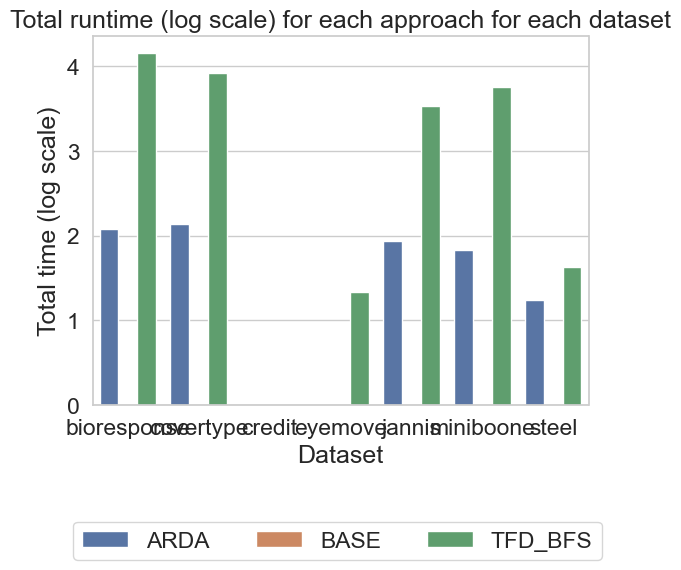

In [48]:


display(total_time.head())

sns.set(font_scale=1.5, style="whitegrid")
colors = sns.color_palette("Set2")

# g = sns.catplot(x="data_label", y="accuracy", hue="approach", data=accuracy, kind="bar", height=4,
#                order=algs)

ax = sns.barplot(data=total_time, x="data_label", y="total_time", hue="approach")


# g.set_titles("{col_name}")
ax.set_xlabel('Dataset')
ax.set_ylabel('Total time (log scale)')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

# g.set_xticklabels(labels, rotation=30)
# g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(1.05, -0.45), loc=4, ncol=3)
ax.set_title("Total runtime (log scale) for each approach for each dataset")

# plt.savefig('plots/2024/total_time_1.png', dpi=300, bbox_inches="tight")



## Total time - all algorithms

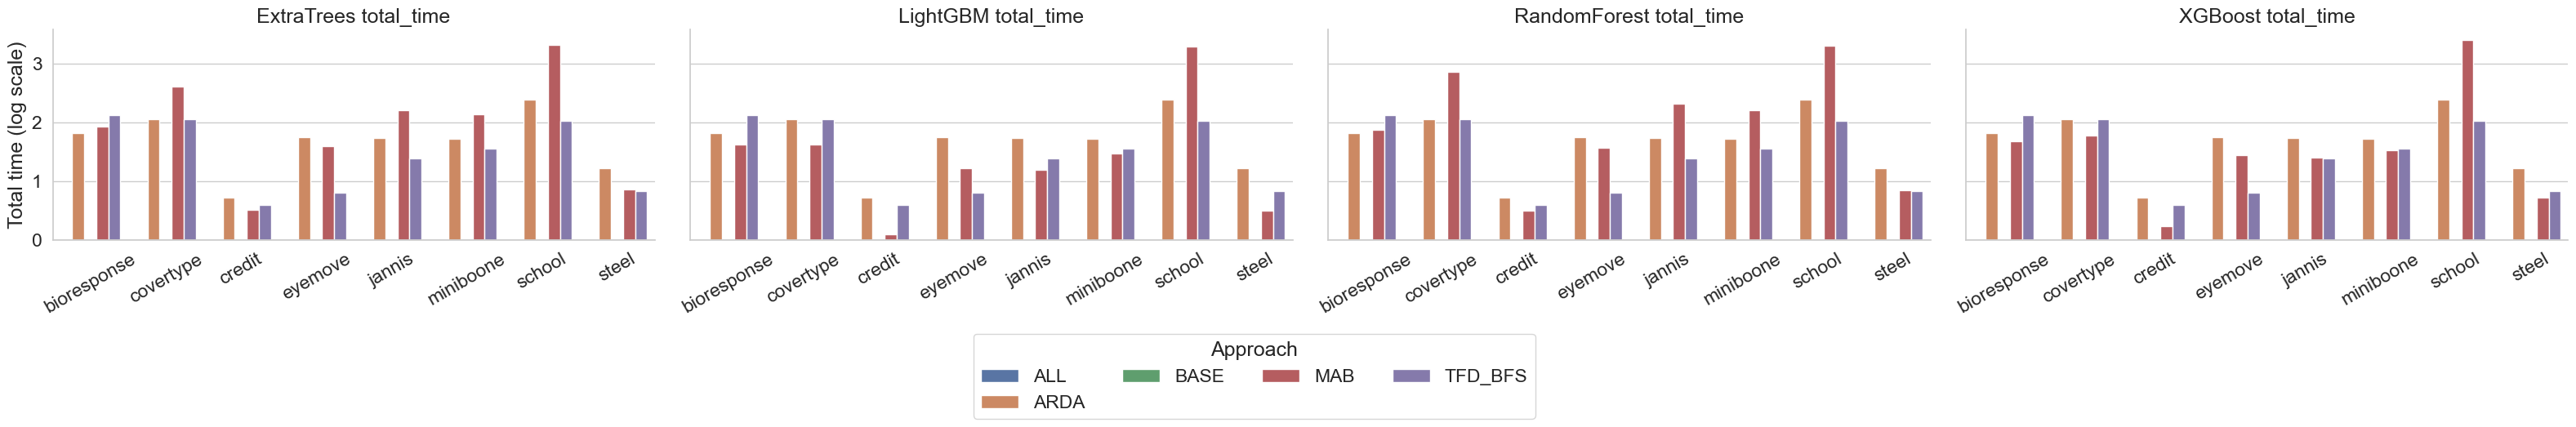

In [16]:
sns.set(font_scale=1.5, style="whitegrid")
# plt.subplots(figsize=(20, 4))

taux = total_time[~total_time['data_label'].isin(['air', 'superconduct', 'yprop'])]


g = sns.catplot(x="data_label", y="total_time", hue="approach", col="algorithm", 
                data=taux, kind="bar", height=4, aspect=2)

g.set_titles("{col_name} total_time")
g.set_xlabels('')
g.set_ylabels('Total time (log scale)')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(-0.7, -0.4), ncol=4, title="Approach")

g.savefig('plots/2024/total_time_8_classification_optimised.png', dpi=300, bbox_inches="tight")


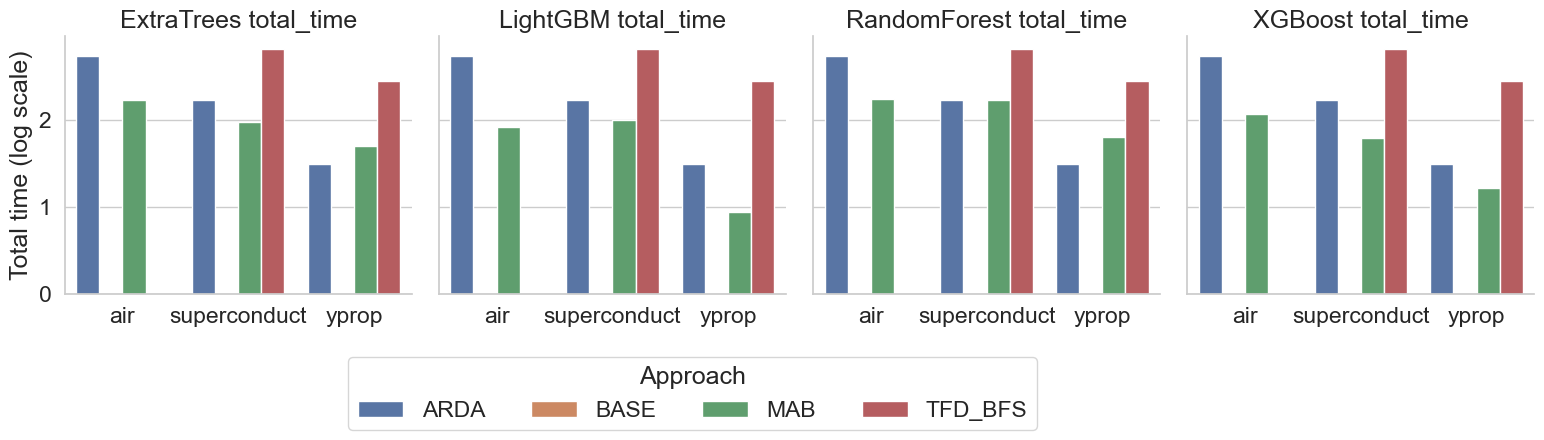

In [134]:
sns.set(font_scale=1.5, style="whitegrid")
# plt.subplots(figsize=(20, 4))

taux = total_time[total_time['data_label'].isin(['air', 'superconduct', 'yprop'])]


g = sns.catplot(x="data_label", y="total_time", hue="approach", col="algorithm", 
                data=taux, kind="bar", height=4, aspect=1)

g.set_titles("{col_name} total_time")
g.set_xlabels('')
g.set_ylabels('Total time (log scale)')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(-0.4, -0.2), ncol=4, title="Approach")

g.savefig('plots/2024/total_time_3_regression.png', dpi=300, bbox_inches="tight")


## Features - one algorithm

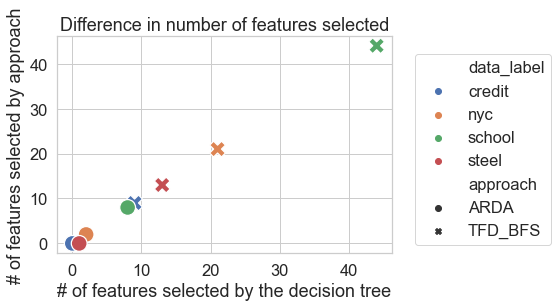

In [100]:
sns.set(font_scale=1.5, style="whitegrid")
colors = sns.color_palette("Set2")

ax = sns.scatterplot(data=feat_df, x="number_features_importance", 
                     y="number_join_path_features", hue="data_label", 
                     style="approach", s=250)

ax.set_xlabel("# of features selected by the decision tree")
ax.set_ylabel("# of features selected by approach")
ax.set_title("Difference in number of features selected")

hh, ll = plt.gca().get_legend_handles_labels()
plt.legend(hh, ll, bbox_to_anchor=(1.5, 0), loc=4, ncol=1)

# plt.savefig('plots/2024/nr_features_1.png', dpi=300, bbox_inches="tight")



## Features - all algorithms

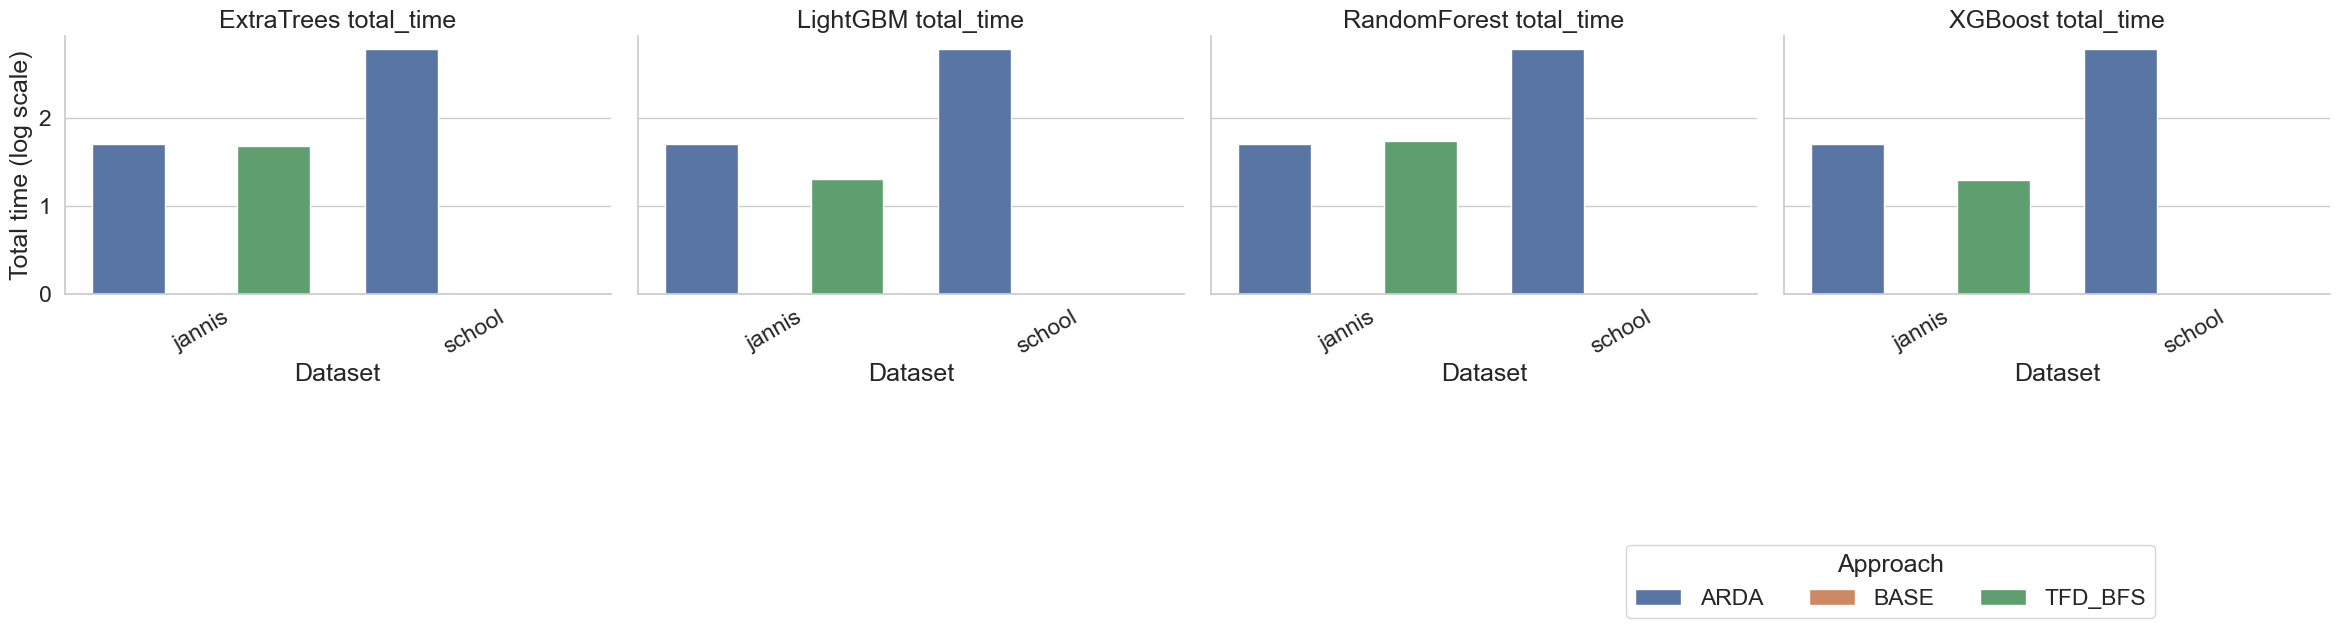

In [24]:
sns.set(font_scale=1.5, style="whitegrid")
# plt.subplots(figsize=(20, 4))

g = sns.catplot(x="data_label", y="total_time", hue="approach", col="algorithm", 
                data=total_time, kind="bar", height=4, aspect=1.5)

g.set_titles("{col_name} total_time")
g.set_xlabels('Dataset')
g.set_ylabels('Total time (log scale)')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(0.7, -1.3), loc=4, ncol=3, title="Approach")

# g.savefig('plots/accuracy-all-big.pdf', dpi=300, bbox_inches="tight")


# 6. Tune threshold - value_ratio

## Analyse data

In [41]:
# read data

value_ratio_result_fileine = "all_results_value_ratio_tuning.csv"
filepath_vr = os.path.join(folder_name, f"{dataset_path}/{value_ratio_result_fileine}")

df_vr = pd.read_csv(filepath_vr)
df_vr.drop(columns=['join_time', 'depth', 'redundancy_threshold', 'rank', 'algorithm', 'approach'], inplace=True)

df_vr

,data_path,data_label,total_time,feature_selection_time,accuracy,train_time,feature_importance,join_path_features,cutoff_threshold
0,housing.csv--Borough-capital_projects2.csv,nyc,67.596903,NaN,0.776199,1.294166,"{'capital_projects2.csv.Project Name': 0.002, ...","['capital_projects2.csv.Project Name', 'capita...",0.15
1,housing.csv--ZipCode(s)-film_permits.csv,nyc,67.596903,NaN,0.852130,2.026331,"{'film_permits.csv.EndDateTime': 0.014, 'film_...","['film_permits.csv.EndDateTime', 'film_permits...",0.15
2,base.csv--DBN-math.csv,school,213.776966,NaN,0.704695,1.817757,"{'math.csv.Level 2 #': 0.0, 'math.csv.Level 4 ...","['math.csv.Level 2 #', 'math.csv.Level 4 #', '...",0.15
3,base.csv--DBN-qr.csv,school,213.776966,NaN,0.701878,0.646538,"{'qr.csv.DBN': 0.0, 'base.csv.School Name': 0....","['qr.csv.DBN', 'base.csv.School Name', 'base.c...",0.15
4,base.csv--DBN-gender.csv--DBN-disc.csv,school,213.776966,NaN,0.707527,2.003247,"{'disc.csv.ADMINISTRATIVE DISTRICT': 0.0, 'dis...","['disc.csv.ADMINISTRATIVE DISTRICT', 'disc.csv...",0.15
...,...,...,...,...,...,...,...,...,...
162,table10.csv--V3-table2.csv--V24-table8.csv--V2...,steel,28.494592,NaN,0.800261,2.228764,"{'table4.csv.V16': 0.011, 'table4.csv.V25': 0....","['table4.csv.V16', 'table4.csv.V25', 'table4.c...",0.95
163,housing.csv--Borough-film_permits.csv,nyc,50.908460,NaN,0.833256,1.689204,"{'film_permits.csv.EndDateTime': 0.0, 'film_pe...","['film_permits.csv.EndDateTime', 'film_permits...",1.00
164,housing.csv--Borough-capital_projects2.csv,nyc,50.908460,NaN,0.780428,1.091349,"{'capital_projects2.csv.Project Name': 0.038, ...","['capital_projects2.csv.Project Name', 'capita...",1.00
165,base.csv--DBN-2013_NYC_School_Survey.csv,school,36.926676,NaN,1.000000,0.994501,{'2013_NYC_School_Survey.csv.Total Communicati...,['2013_NYC_School_Survey.csv.Total Communicati...,1.00


## Fix time 

In [42]:
df_vr['feature_selection_time'] = df_vr['total_time']
df_vr['total_time'] = df_vr['feature_selection_time'] + df_vr['train_time']
df_vr

,data_path,data_label,total_time,feature_selection_time,accuracy,train_time,feature_importance,join_path_features,cutoff_threshold
0,housing.csv--Borough-capital_projects2.csv,nyc,68.891069,67.596903,0.776199,1.294166,"{'capital_projects2.csv.Project Name': 0.002, ...","['capital_projects2.csv.Project Name', 'capita...",0.15
1,housing.csv--ZipCode(s)-film_permits.csv,nyc,69.623234,67.596903,0.852130,2.026331,"{'film_permits.csv.EndDateTime': 0.014, 'film_...","['film_permits.csv.EndDateTime', 'film_permits...",0.15
2,base.csv--DBN-math.csv,school,215.594723,213.776966,0.704695,1.817757,"{'math.csv.Level 2 #': 0.0, 'math.csv.Level 4 ...","['math.csv.Level 2 #', 'math.csv.Level 4 #', '...",0.15
3,base.csv--DBN-qr.csv,school,214.423504,213.776966,0.701878,0.646538,"{'qr.csv.DBN': 0.0, 'base.csv.School Name': 0....","['qr.csv.DBN', 'base.csv.School Name', 'base.c...",0.15
4,base.csv--DBN-gender.csv--DBN-disc.csv,school,215.780213,213.776966,0.707527,2.003247,"{'disc.csv.ADMINISTRATIVE DISTRICT': 0.0, 'dis...","['disc.csv.ADMINISTRATIVE DISTRICT', 'disc.csv...",0.15
...,...,...,...,...,...,...,...,...,...
162,table10.csv--V3-table2.csv--V24-table8.csv--V2...,steel,30.723356,28.494592,0.800261,2.228764,"{'table4.csv.V16': 0.011, 'table4.csv.V25': 0....","['table4.csv.V16', 'table4.csv.V25', 'table4.c...",0.95
163,housing.csv--Borough-film_permits.csv,nyc,52.597664,50.908460,0.833256,1.689204,"{'film_permits.csv.EndDateTime': 0.0, 'film_pe...","['film_permits.csv.EndDateTime', 'film_permits...",1.00
164,housing.csv--Borough-capital_projects2.csv,nyc,51.999809,50.908460,0.780428,1.091349,"{'capital_projects2.csv.Project Name': 0.038, ...","['capital_projects2.csv.Project Name', 'capita...",1.00
165,base.csv--DBN-2013_NYC_School_Survey.csv,school,37.921177,36.926676,1.000000,0.994501,{'2013_NYC_School_Survey.csv.Total Communicati...,['2013_NYC_School_Survey.csv.Total Communicati...,1.00


## Process data

In [51]:
number_of_features, features = parse_feature_importance(df_vr)
df_vr['number_features_importance'] = number_of_features

number_of_features, jp_features = parse_join_path_features(df_vr)
df_vr['number_join_path_features'] = number_of_features

nr_common_features, difference = determine_common_features(df_vr)
df_vr['nr_common_features'] = nr_common_features
df_vr['different_features'] = difference

df_vr

[11, 19, 20, 6, 23, 8, 37, 22, 12, 19, 11, 19, 20, 6, 29, 8, 42, 37, 41, 22, 12, 7, 28, 11, 19, 20, 37, 22, 41, 12, 9, 24, 11, 19, 20, 23, 22, 12, 9, 16, 11, 19, 23, 20, 6, 47, 23, 8, 22, 22, 56, 12, 7, 9, 27, 11, 19, 8, 20, 6, 44, 22, 22, 12, 9, 20, 11, 19, 8, 20, 37, 22, 22, 12, 16, 11, 19, 23, 20, 44, 20, 22, 12, 7, 9, 20, 11, 19, 8, 20, 23, 22, 22, 56, 12, 9, 24, 11, 19, 20, 6, 23, 22, 22, 56, 12, 9, 16, 11, 19, 6, 29, 8, 22, 22, 12, 7, 9, 16, 11, 19, 22, 22, 12, 7, 23, 11, 19, 29, 8, 22, 22, 14, 7, 9, 16, 11, 16, 22, 22, 12, 7, 28, 16, 11, 18, 15, 22, 12, 8, 9, 14, 16, 11, 22, 12, 17, 16, 11, 22, 12, 9, 22, 16, 11, 12, 16]
[11, 19, 20, 6, 23, 8, 37, 22, 12, 19, 11, 19, 20, 6, 29, 8, 42, 37, 41, 22, 12, 7, 28, 11, 19, 20, 37, 22, 41, 12, 9, 24, 11, 19, 20, 23, 22, 12, 9, 16, 11, 19, 23, 20, 6, 47, 23, 8, 22, 22, 56, 12, 7, 9, 27, 11, 19, 8, 20, 6, 44, 22, 22, 12, 9, 20, 11, 19, 8, 20, 37, 22, 22, 12, 16, 11, 19, 23, 20, 44, 20, 22, 12, 7, 9, 20, 11, 19, 8, 20, 23, 22, 22, 56, 12, 9

,data_path,data_label,total_time,feature_selection_time,accuracy,train_time,feature_importance,join_path_features,cutoff_threshold,number_features_importance,number_join_path_features,nr_common_features,different_features
0,housing.csv--Borough-capital_projects2.csv,nyc,68.891069,67.596903,0.776199,1.294166,"{'capital_projects2.csv.Project Name': 0.002, ...","['capital_projects2.csv.Project Name', 'capita...",0.15,11,11,11,{}
1,housing.csv--ZipCode(s)-film_permits.csv,nyc,69.623234,67.596903,0.852130,2.026331,"{'film_permits.csv.EndDateTime': 0.014, 'film_...","['film_permits.csv.EndDateTime', 'film_permits...",0.15,19,19,19,{}
2,base.csv--DBN-math.csv,school,215.594723,213.776966,0.704695,1.817757,"{'math.csv.Level 2 #': 0.0, 'math.csv.Level 4 ...","['math.csv.Level 2 #', 'math.csv.Level 4 #', '...",0.15,20,20,20,{}
3,base.csv--DBN-qr.csv,school,214.423504,213.776966,0.701878,0.646538,"{'qr.csv.DBN': 0.0, 'base.csv.School Name': 0....","['qr.csv.DBN', 'base.csv.School Name', 'base.c...",0.15,6,6,6,{}
4,base.csv--DBN-gender.csv--DBN-disc.csv,school,215.780213,213.776966,0.707527,2.003247,"{'disc.csv.ADMINISTRATIVE DISTRICT': 0.0, 'dis...","['disc.csv.ADMINISTRATIVE DISTRICT', 'disc.csv...",0.15,23,23,23,{}
...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,table10.csv--V3-table2.csv--V24-table8.csv--V2...,steel,30.723356,28.494592,0.800261,2.228764,"{'table4.csv.V16': 0.011, 'table4.csv.V25': 0....","['table4.csv.V16', 'table4.csv.V25', 'table4.c...",0.95,22,22,22,{}
163,housing.csv--Borough-film_permits.csv,nyc,52.597664,50.908460,0.833256,1.689204,"{'film_permits.csv.EndDateTime': 0.0, 'film_pe...","['film_permits.csv.EndDateTime', 'film_permits...",1.00,16,16,16,{}
164,housing.csv--Borough-capital_projects2.csv,nyc,51.999809,50.908460,0.780428,1.091349,"{'capital_projects2.csv.Project Name': 0.038, ...","['capital_projects2.csv.Project Name', 'capita...",1.00,11,11,11,{}
165,base.csv--DBN-2013_NYC_School_Survey.csv,school,37.921177,36.926676,1.000000,0.994501,{'2013_NYC_School_Survey.csv.Total Communicati...,['2013_NYC_School_Survey.csv.Total Communicati...,1.00,12,12,12,{}


## Plot

In [55]:
threshold = df_vr.groupby(['cutoff_threshold', 'data_label'])[['total_time', 'accuracy']].max().reset_index()
threshold 


,cutoff_threshold,data_label,total_time,accuracy
0,0.15,nyc,69.623234,0.852130
1,0.15,school,217.171951,1.000000
2,0.15,steel,23.865264,0.777713
3,0.20,nyc,63.183314,0.851685
4,0.20,school,318.169488,1.000000
...,...,...,...,...
60,0.95,school,44.272763,1.000000
61,0.95,steel,30.723356,0.800261
62,1.00,nyc,52.597664,0.833256
63,1.00,school,37.921177,1.000000


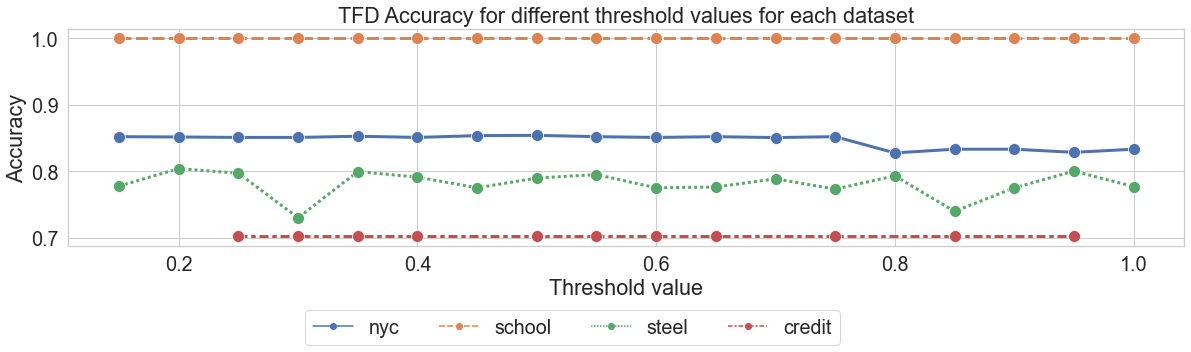

In [84]:
sns.set(font_scale=1.8, style="whitegrid")
plt.subplots(figsize=(20, 4))

# ax = sns.barplot(data=threshold, x="cutoff_threshold", y="accuracy", hue="data_label")

# ax = sns.scatterplot(data=threshold, x="cutoff_threshold", 
#                      y="accuracy",  
#                      style="data_label", s=250)
ax = sns.lineplot(data=threshold, x="cutoff_threshold", 
                     y="accuracy", hue="data_label",
                     style="data_label", markers=['o','o','o','o'], markersize=12, linewidth=3)

ax.set_xlabel('Threshold value')
ax.set_ylabel('Accuracy')

hh, ll = plt.gca().get_legend_handles_labels()

plt.legend(hh, ll, bbox_to_anchor=(0.7, -0.5), loc=4, ncol=4)
ax.set_title("TFD Accuracy for different threshold values for each dataset")

plt.savefig('plots/2024/threshold_1.png', dpi=300, bbox_inches="tight")


# 7. Ablation

## Read data

In [147]:
# read data

ablation_filename = "ablation_study_0.5.csv"
filepath_abl = os.path.join(folder_name, f"{dataset_path}/{ablation_filename}")

ablation = pd.read_csv(filepath_abl)

ablation

,study,nyc_paths,nyc_runtime,school_paths,school_runtime,credit_paths,credit_runtime,steel_paths,steel_runtime
0,enumerate,11,16.090323,1104,1.818853,1,0.365223,139,0.456157
1,enumerate_join,11,97.804418,1104,894.550517,1,2.249067,139,70.750071
2,enumerate_prune,5,68.508469,76,103.639486,1,3.243296,139,76.397723
3,enumerate_join_prune_fs,5,94.340995,76,1100.108041,1,2.793950,69,161.210917
4,enumerate_join_prune_fs_rank_jk,5,103.161171,41,1012.976641,1,3.443817,38,176.144711


## Create dataframes for plots

In [148]:
ablation_paths = ablation[['study', 'nyc_paths', 'school_paths', 'credit_paths', 'steel_paths']]
ablation_paths = ablation_paths.set_index('study').stack().reset_index(name="value").rename(columns={'level_1': 'type'})
ablation_paths

,study,type,value
0,enumerate,nyc_paths,11
1,enumerate,school_paths,1104
2,enumerate,credit_paths,1
3,enumerate,steel_paths,139
4,enumerate_join,nyc_paths,11
5,enumerate_join,school_paths,1104
6,enumerate_join,credit_paths,1
7,enumerate_join,steel_paths,139
8,enumerate_prune,nyc_paths,5
9,enumerate_prune,school_paths,76


In [149]:
ablation_runtime = ablation[['study', 'nyc_runtime', 'school_runtime', 'credit_runtime', 'steel_runtime']]
ablation_runtime = ablation_runtime.set_index('study').stack().reset_index(name="value").rename(columns={'level_1': 'type'})
ablation_runtime

,study,type,value
0,enumerate,nyc_runtime,16.090323
1,enumerate,school_runtime,1.818853
2,enumerate,credit_runtime,0.365223
3,enumerate,steel_runtime,0.456157
4,enumerate_join,nyc_runtime,97.804418
5,enumerate_join,school_runtime,894.550517
6,enumerate_join,credit_runtime,2.249067
7,enumerate_join,steel_runtime,70.750071
8,enumerate_prune,nyc_runtime,68.508469
9,enumerate_prune,school_runtime,103.639486


## Plots

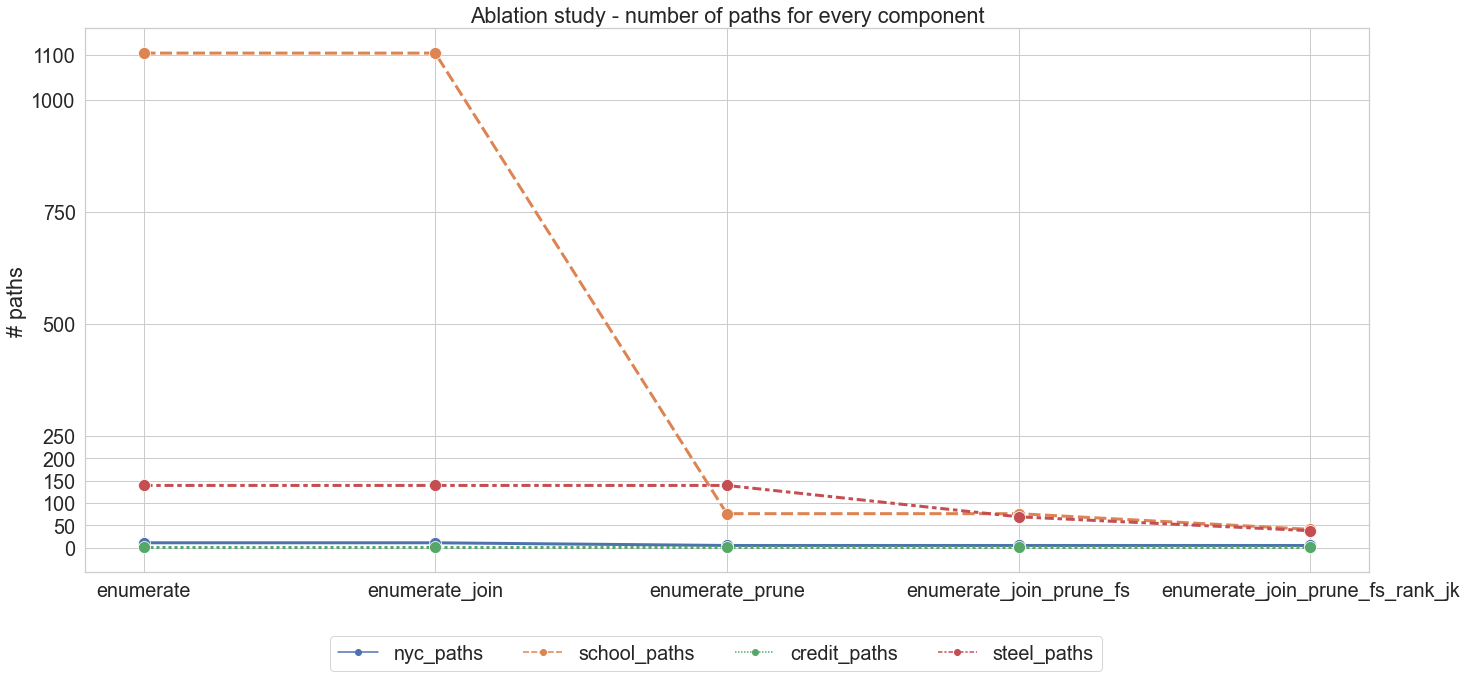

In [152]:
sns.set(font_scale=1.8, style="whitegrid")
plt.subplots(figsize=(23, 10))

ax = sns.lineplot(data=ablation_paths, x="study", 
                     y="value", hue="type",
                     style="type", markers=['o','o','o','o'], markersize=12, linewidth=3)

ax.set_xlabel('')
ax.set_ylabel('# paths')

ax.set_yticks([0, 50, 100, 150, 200, 250, 500, 750, 1000, 1100])


hh, ll = plt.gca().get_legend_handles_labels()

plt.legend(hh, ll, bbox_to_anchor=(0.8, -0.2), loc=4, ncol=4)
ax.set_title("Ablation study - number of paths for every component")

plt.savefig('plots/2024/ablation_paths_1.png', dpi=300, bbox_inches="tight")


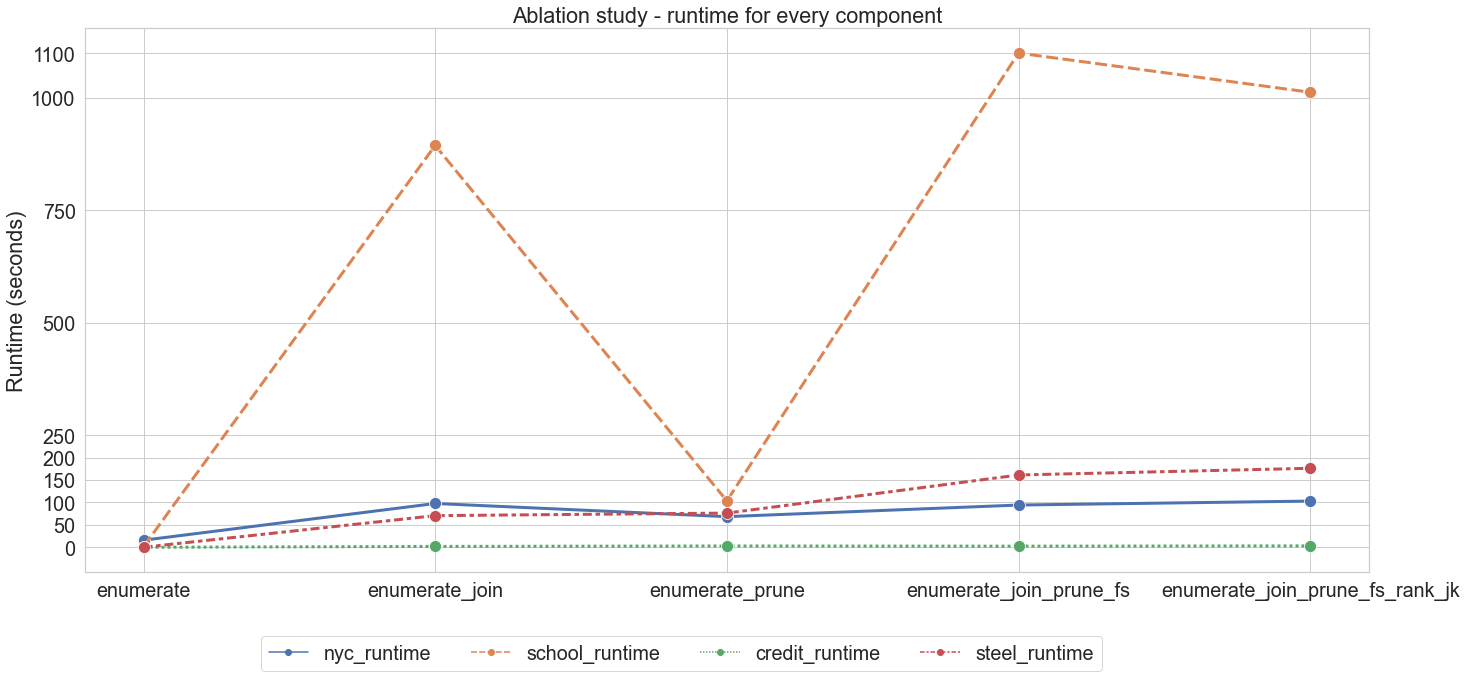

In [153]:
sns.set(font_scale=1.8, style="whitegrid")
plt.subplots(figsize=(23, 10))

ax = sns.lineplot(data=ablation_runtime, x="study", 
                     y="value", hue="type",
                     style="type", markers=['o','o','o','o'], markersize=12, linewidth=3)

ax.set_xlabel('')
ax.set_ylabel('Runtime (seconds)')

ax.set_yticks([0, 50, 100, 150, 200, 250, 500, 750, 1000, 1100])


hh, ll = plt.gca().get_legend_handles_labels()

plt.legend(hh, ll, bbox_to_anchor=(0.8, -0.2), loc=4, ncol=4)
ax.set_title("Ablation study - runtime for every component")

plt.savefig('plots/2024/ablation_runtime_1.png', dpi=300, bbox_inches="tight")


In [3]:
# get original (base) table name from dataset name 

def shorten_dataset_name_join(data):
    if 'other-data' in data:
        partition = data.partition('other-data')[2]
        split = partition.split('/')[-1]
    else:
        split = data.split('/')[0]
    return split

def half_time(data):
    if 'other-data' in data:
        partition = data.partition('other-data')[2]
        split = partition.split('/')[-1]
    else:
        split = data.split('/')[0]
    return split

dataframe['dataset'] = dataframe['data_path'].apply(lambda x: shorten_dataset_name_join(x))

dataframe


,approach,data_path,algorithm,depth,accuracy,join_time,train_time,total_time,feature_importances,fs_time,dataset
0,all-in-path,football/football.csv/id--football/differences...,CART,2.0,0.798761,2.075651,0.081938,2.157589,{'strong_score': 1.0},NaN,football
1,all-in-path,football/football.csv/id--football/differences...,ID3,2.0,0.519043,2.075651,269.792025,271.867676,{},NaN,football
2,all-in-path,football/football.csv/id--football/differences...,XGBoost,1.0,0.784404,2.075651,0.772123,2.847774,"{'date': 0.033, 'weak_team': 0.018, 'dif_overa...",NaN,football
3,best-ranked,football/football.csv/id--football/differences...,CART,4.0,0.785202,2.075651,0.087464,2.163115,"{'date': 0.022, 'dif_midfield': 0.016, 'id': 0...",NaN,football
4,best-ranked,football/football.csv/id--football/differences...,ID3,4.0,0.528358,2.075651,173.252891,175.328542,{},NaN,football
...,...,...,...,...,...,...,...,...,...,...,...
103,non-aug,other-data/decision-trees-split/titanic,ID3,2.0,0.383783,NaN,28.246128,28.246128,{},NaN,titanic
104,non-aug,other-data/decision-trees-split/titanic,XGBoost,1.0,0.562484,NaN,0.140772,0.140772,"{'PassengerId': 0.491, 'TicketId': 0.509}",NaN,titanic
105,non-aug,other-data/data/WebKP 2,CART,1.0,0.470925,NaN,0.012028,0.012028,{'webpage_id': 1.0},NaN,WebKP 2
106,non-aug,other-data/data/WebKP 2,ID3,2.0,0.091131,NaN,13.375112,13.375112,{},NaN,WebKP 2


In [4]:
df1 = dataframe[(dataframe['approach']=='best-ranked') | (dataframe['approach']=='all-in-path')]

df1['join_time'] = dataframe.apply(lambda x: x['join_time']/2, axis=1)
df1['total_time'] = dataframe.apply(lambda x: x['total_time']/2, axis=1)
df1['train_time'] = dataframe.apply(lambda x: x['train_time']/2, axis=1)

df2 = dataframe[(dataframe['approach']!='best-ranked')  & (dataframe['approach']!='all-in-path')]

df = pd.concat([df1, df2])
df['approach'].unique()


/var/folders/qt/6fl05zbd1qg522c_08dv10f40000gn/T/ipykernel_36572/3298512316.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['join_time'] = dataframe.apply(lambda x: x['join_time']/2, axis=1)
/var/folders/qt/6fl05zbd1qg522c_08dv10f40000gn/T/ipykernel_36572/3298512316.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['total_time'] = dataframe.apply(lambda x: x['total_time']/2, axis=1)
/var/folders/qt/6fl05zbd1qg522c_08dv10f40000gn/T/ipykernel_36572/3298512316.py:5: SettingWithCopyWarning: 
A val

array(['all-in-path', 'best-ranked', 'join_all', 'arda', 'join_all_ffs',
       'non-aug'], dtype=object)

In [4]:
best_ranked = dataframe[dataframe['approach']=='best-ranked']
# display(best_ranked)

all_path = dataframe[dataframe['approach']=='all-in-path']
# display(all_path)

join_all = dataframe[dataframe['approach']=='join_all']
# display(join_all)

arda = dataframe[dataframe['approach']=='arda']
# display(best_ranked)

join_all_ffs = dataframe[dataframe['approach']=='join_all_ffs']
# display(all_path)

non_aug = dataframe[dataframe['approach']=='non-aug']
# display(join_all)


best_ranked_df = best_ranked.groupby(['dataset', 'algorithm', 'depth', 'approach'])['total_time'].max().to_frame(name='accuracy').reset_index()
display(best_ranked_df)


,dataset,algorithm,depth,approach,accuracy
0,football,CART,2.0,best-ranked,6.190797
1,football,ID3,4.0,best-ranked,170.645855
2,football,XGBoost,1.0,best-ranked,6.553480
3,steel-plate-fault,CART,9.0,best-ranked,85.162665
4,steel-plate-fault,ID3,4.0,best-ranked,509.314594
5,steel-plate-fault,XGBoost,11.0,best-ranked,89.028154
6,titanic,CART,3.0,best-ranked,0.588195
7,titanic,ID3,2.0,best-ranked,169.759674
8,titanic,XGBoost,1.0,best-ranked,0.890371


In [7]:
# train time
total_time = None
for approach in df['approach'].unique():
    dff = df[df['approach']==approach]
    dff = dff.groupby(['dataset', 'algorithm', 'depth', 'approach'])['total_time'].max().to_frame(name='total_time').reset_index()
    if total_time is None:
        total_time = dff
    else:
        total_time = pd.concat([total_time, dff])
        
display(total_time)

,dataset,algorithm,depth,approach,total_time
0,football,CART,6.0,arda,31.876689
1,football,ID3,4.0,arda,72.093538
2,football,XGBoost,2.0,arda,32.415981
3,steel-plate-fault,CART,4.0,arda,217.050151
4,steel-plate-fault,ID3,8.0,arda,218.328975
5,steel-plate-fault,XGBoost,1.0,arda,217.477362
6,titanic,CART,1.0,arda,5.859683
7,titanic,ID3,2.0,arda,6.029064
8,titanic,XGBoost,1.0,arda,6.085378
0,football,CART,10.0,join_all,0.408521


In [8]:
depth = None
for approach in dataframe['approach'].unique():
    dff = dataframe[dataframe['approach']==approach]
    dff = dff.groupby(['dataset', 'algorithm', 'approach'])['depth'].max().to_frame(name='depth').reset_index()
    if depth is None:
        depth = dff
    else:
        depth = pd.concat([depth, dff])

In [9]:
join_time = None
for approach in df['approach'].unique():
    dff = df[df['approach']==approach]
    dff = df[(df['dataset']!='PubMed_Diabetes') & (df['dataset']!='CiteSeer') & (df['dataset']!='CORA')]
    dff = dff.groupby(['dataset', 'algorithm', 'depth', 'approach'])['join_time'].max().to_frame(name='join_time').reset_index()
    if join_time is None:
        join_time = dff
    else:
        join_time = pd.concat([join_time, dff])

In [10]:
# Separate into 2 datasets
small_datasets = ['football', 'steel-plate-fault', 'titanic']
big_datasets = ['CORA', 'WebKP 2', 'CiteSeer']

,dataset,algorithm,depth,approach,accuracy
3,CiteSeer,CART,2.0,best-ranked,0.230067
13,football,ID3,4.0,best-ranked,0.528358
16,steel-plate-fault,ID3,4.0,best-ranked,0.355155
4,CiteSeer,ID3,2.0,best-ranked,0.201704
19,titanic,ID3,2.0,best-ranked,0.383783


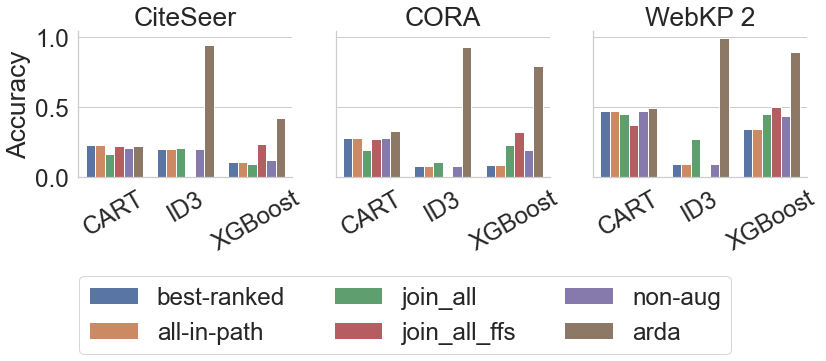

In [16]:
# Accuracy of BestRank, JoinAll and Non-Aug

# BIG DATASETS

display(accuracy.head())

label_order = {'best-ranked': 0, 'all-in-path': 1, 'join_all': 2, 'join_all_ffs': 3, 'non-aug': 4, 'arda': 5}

accuracy.sort_values(by=['algorithm'], ascending=True, inplace=True)
accuracy.sort_values(by=['approach'], key=lambda x: x.map(label_order), inplace=True)

accuracy_filtered = accuracy[accuracy["dataset"].isin(big_datasets)]
# accuracy_filtered = accuracy_filtered[accuracy_filtered["approach"] != "arda"]


sns.set(font_scale=2.2, style="whitegrid")
colors = sns.color_palette("Set2")

g = sns.catplot(x="algorithm", y="accuracy", hue="approach", col="dataset", data=accuracy_filtered, kind="bar", height=4,
               order=algs)

g.set_titles("{col_name}")
g.set_xlabels('')
g.set_ylabels('Accuracy')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(0.7, -1.3), loc=4, ncol=3)

g.savefig('plots/accuracy-all-big.pdf', dpi=300, bbox_inches="tight")




,dataset,algorithm,depth,approach,total_time
0,football,CART,2.0,best-ranked,6.190797
1,football,ID3,4.0,best-ranked,170.645855
2,football,XGBoost,1.0,best-ranked,6.553480
3,steel-plate-fault,CART,9.0,best-ranked,85.162665
4,steel-plate-fault,ID3,4.0,best-ranked,509.314594


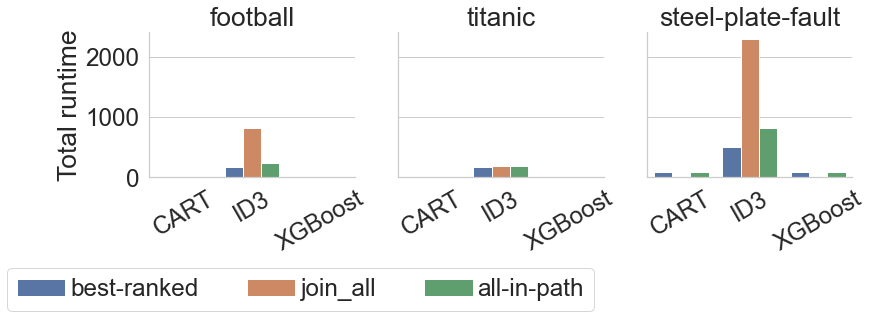

In [16]:
# Accuracy of BestRank, JoinAll and Non-Aug

best_ranked = df[df['approach']=='best-ranked']
# display(best_ranked)

all_path = df[df['approach']=='all-in-path']
# display(all_path)

join_all = df[df['approach']=='join_all']
# display(join_all)

best_ranked_df = best_ranked.groupby(['dataset', 'algorithm', 'depth', 'approach'])['total_time'].max().to_frame(name='total_time').reset_index()

all_path_df = all_path.groupby(['dataset', 'algorithm', 'depth', 'approach'])['total_time'].max().to_frame(name='total_time').reset_index()

join_all_df = join_all.groupby(['dataset', 'algorithm', 'depth', 'approach'])['total_time'].max().to_frame(name='total_time').reset_index()

concat_df = pd.concat([best_ranked_df, all_path_df, join_all_df])

display(concat_df.head())

# label_order = {'best-ranked': 0, 'all-in-path': 1, 'join_all': 2}

concat_df.sort_values(by=['algorithm'], ascending=True, inplace=True)
# concat_df.sort_values(by=['approach'], key=lambda x: x.map(label_order), inplace=True)


sns.set(font_scale=2.2, style="whitegrid")
colors = sns.color_palette("Set2")

g = sns.catplot(x="algorithm", y="total_time", hue="approach", col="dataset", data=concat_df, kind="bar", height=4,
               order=algs)

g.set_titles("{col_name}")
g.set_xlabels('')
g.set_ylabels('Total runtime')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(-0.2, -1), loc=4, ncol=3, handletextpad=0.2)

g.savefig('plots/runtime-all.pdf', dpi=300, bbox_inches="tight")





,dataset,algorithm,depth,approach,join_time
0,football,CART,1.0,non-aug,NaN
18,steel-plate-fault,CART,6.0,all-in-path,85.046816
19,steel-plate-fault,CART,6.0,join_all,0.186446
20,steel-plate-fault,CART,6.0,non-aug,NaN
21,steel-plate-fault,CART,9.0,best-ranked,85.046816
...,...,...,...,...,...
49,titanic,XGBoost,2.0,join_all,0.064785
11,football,XGBoost,1.0,all-in-path,6.125426
12,football,XGBoost,1.0,best-ranked,6.125426
45,titanic,XGBoost,1.0,all-in-path,0.513113


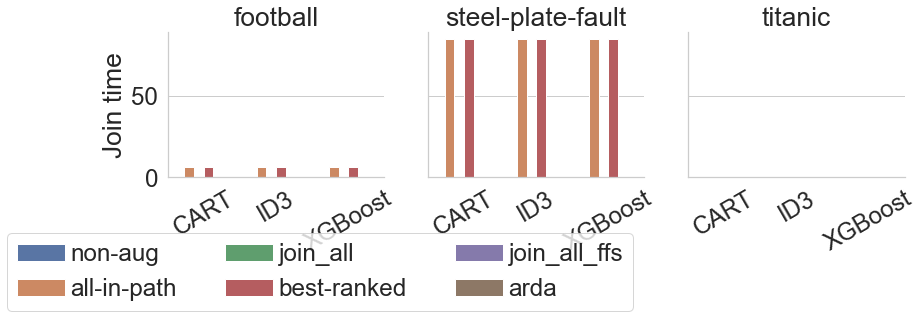

In [17]:



# label_order = {'best-ranked': 0, 'all-in-path': 1, 'join_all': 2}

### SMALL DATASETS JOIN TIME

join_time.sort_values(by=['algorithm'], ascending=True, inplace=True)
# join_time.sort_values(by=['approach'], key=lambda x: x.map(label_order), inplace=True)
join_time_filtered = join_time[join_time['dataset'].isin(small_datasets)]

display(join_time)


sns.set(font_scale=2.2, style="whitegrid")
colors = sns.color_palette("Set2")

g = sns.catplot(x="algorithm", y="join_time", hue="approach", col="dataset", data=join_time_filtered, kind="bar", height=4,
               order=algs)

g.set_titles("{col_name}")
g.set_xlabels('')
g.set_ylabels('Join time')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(-0.2, -1), loc=4, ncol=3, handletextpad=0.2)

g.savefig('plots/join-time-all.pdf', dpi=300, bbox_inches="tight")




In [18]:
train_time = None
for approach in df['approach'].unique():
    dff = df[df['approach']==approach]
#     dff = dataframe[(dataframe['dataset']!='PubMed_Diabetes') & (dataframe['dataset']!='CiteSeer') & (dataframe['dataset']!='CORA')]
    dff = dff.groupby(['dataset', 'algorithm', 'approach'])['train_time'].max().to_frame(name='train_time').reset_index()
    if train_time is None:
        train_time = dff
    else:
        train_time = pd.concat([train_time, dff])

,dataset,algorithm,approach,train_time
0,football,CART,arda,-2.721879+0.000000j
3,steel-plate-fault,CART,arda,-2.811296+0.000000j
6,titanic,CART,best-ranked,-2.589174+0.000000j
6,titanic,CART,arda,-2.680222+0.000000j
3,steel-plate-fault,CART,best-ranked,-2.155470+0.000000j
0,football,CART,best-ranked,-2.727676+0.000000j
4,steel-plate-fault,ID3,arda,0.291886+0.000000j
7,titanic,ID3,arda,-1.435784+0.000000j
1,football,ID3,arda,3.695920+0.000000j
1,football,ID3,best-ranked,5.103035+0.000000j


/Users/andra/Developer/auto-data-augmentation/ada/lib/python3.8/site-packages/matplotlib/transforms.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/Users/andra/Developer/auto-data-augmentation/ada/lib/python3.8/site-packages/matplotlib/transforms.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/Users/andra/Developer/auto-data-augmentation/ada/lib/python3.8/site-packages/matplotlib/transforms.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/Users/andra/Developer/auto-data-augmentation/ada/lib/python3.8/site-packages/matplotlib/transforms.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


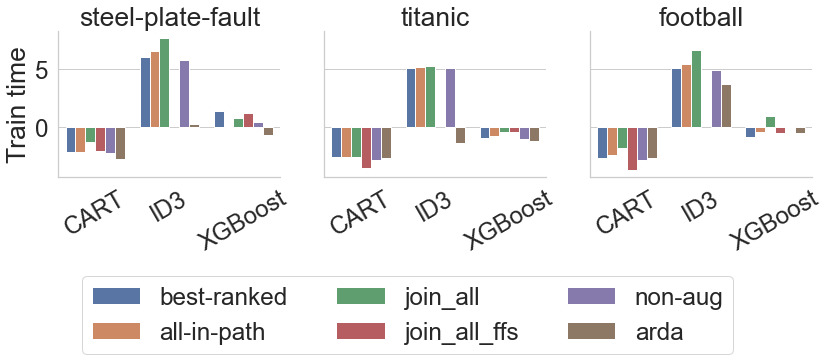

In [20]:
# Accuracy of BestRank, JoinAll and Non-Aug
from cmath import log

# display(train_time)

#### TRAIN TIME small datasets
label_order = {'best-ranked': 0, 'all-in-path': 1, 'join_all': 2, 'join_all_ffs': 3, 'non-aug': 4, 'arda': 5}

train_time.sort_values(by=['algorithm'], ascending=True, inplace=True)
train_time_filtered = train_time[train_time['dataset'].isin(small_datasets)]
train_time_filtered['train_time'] = train_time_filtered.apply(lambda row: log(row['train_time']), axis=1)
display(train_time_filtered[(train_time_filtered['approach'] == 'best-ranked') | (train_time_filtered['approach'] == 'arda')])
train_time_filtered.sort_values(by=['approach'], key=lambda x: x.map(label_order), inplace=True)


sns.set(font_scale=2.2, style="whitegrid")
colors = sns.color_palette("Set2")

g = sns.catplot(x="algorithm", y="train_time", hue="approach", col="dataset", data=train_time_filtered, kind="bar", height=4,
               order=algs)

g.set_titles("{col_name}")
g.set_xlabels('')
g.set_ylabels('Train time')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(0.7, -1.3), loc=4, ncol=3)

g.savefig('plots/train-time-all-small.pdf', dpi=300, bbox_inches="tight")

/var/folders/qt/6fl05zbd1qg522c_08dv10f40000gn/T/ipykernel_36572/193570243.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_time_filtered['train_time'] = train_time_filtered.apply(lambda row: log(row['train_time']), axis=1)
/Users/andra/Developer/auto-data-augmentation/ada/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/Users/andra/Developer/auto-data-augmentation/ada/lib/python3.8/site-packages/matplotlib/transforms.py:774: ComplexWarning: Casting complex values to 

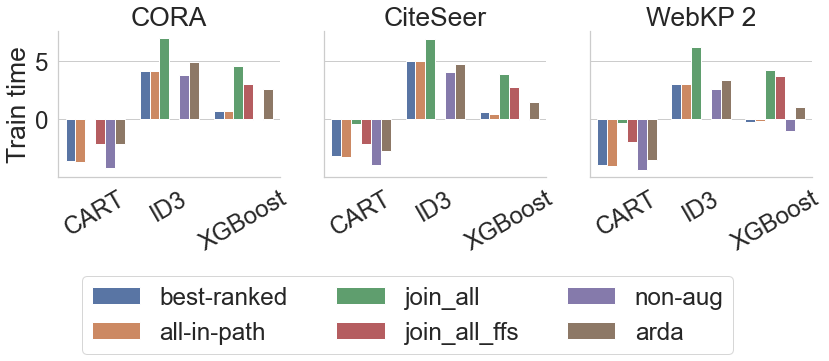

In [27]:
# Accuracy of BestRank, JoinAll and Non-Aug

from cmath import log
# display(train_time)

#### TRAIN TIME BIG datasets
train_time_filtered
train_time.sort_values(by=['algorithm'], ascending=True, inplace=True)
train_time_filtered = train_time[train_time['dataset'].isin(big_datasets)]
# train_time_filtered = train_time_filtered[train_time_filtered['approach'] != 'join_all']
train_time_filtered['train_time'] = train_time_filtered.apply(lambda row: log(row['train_time']), axis=1)
train_time_filtered.sort_values(by=['approach'], key=lambda x: x.map(label_order), inplace=True)


sns.set(font_scale=2.2, style="whitegrid")
colors = sns.color_palette("Set2")

g = sns.catplot(x="algorithm", y="train_time", hue="approach", col="dataset", data=train_time_filtered, kind="bar", height=4,
               order=algs)

g.set_titles("{col_name}")
g.set_xlabels('')
g.set_ylabels('Train time')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(0.7, -1.3), loc=4, ncol=3)

g.savefig('plots/train-time-all-big.pdf', dpi=300, bbox_inches="tight")

,dataset,algorithm,approach,depth
0,football,CART,arda,6.0
3,steel-plate-fault,CART,all-in-path,6.0
4,titanic,CART,join_all_ffs,2.0
2,steel-plate-fault,CART,join_all_ffs,13.0
6,titanic,CART,all-in-path,5.0


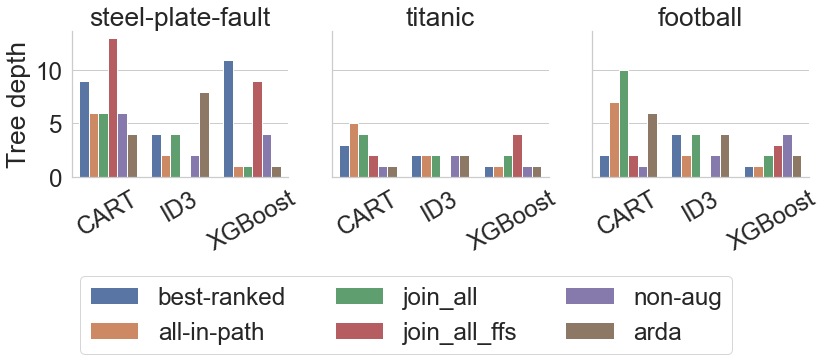

In [17]:

display(depth.head())

# DEPTH SMALL labels
# label_order = {'best-ranked': 0, 'all-in-path': 1, 'join_all': 2}

depth.sort_values(by=['algorithm'], ascending=True, inplace=True)
depth_filtered = depth[depth["dataset"].isin(small_datasets)]
depth_filtered.sort_values(by=['approach'], key=lambda x: x.map(label_order), inplace=True)


sns.set(font_scale=2.2, style="whitegrid")
colors = sns.color_palette("Set2")

g = sns.catplot(x="algorithm", y="depth", hue="approach", col="dataset", data=depth_filtered, kind="bar", height=4,
               order=algs)

g.set_titles("{col_name}")
g.set_xlabels('')
g.set_ylabels('Tree depth')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(0.7, -1.3), loc=4, ncol=3)

g.savefig('plots/depth-all-small.png', dpi=300, bbox_inches="tight")





In [16]:
display(depth.head())

# DEPTH BIG labels
# label_order = {'best-ranked': 0, 'all-in-path': 1, 'join_all': 2}

depth.sort_values(by=['algorithm'], ascending=True, inplace=True)
depth_filtered = depth[depth["dataset"].isin(big_datasets)]
depth_filtered.sort_values(by=['approach'], key=lambda x: x.map(label_order), inplace=True)


sns.set(font_scale=2.2, style="whitegrid")
colors = sns.color_palette("Set2")

g = sns.catplot(x="algorithm", y="depth", hue="approach", col="dataset", data=depth_filtered, kind="bar", height=4,
               order=algs)

g.set_titles("{col_name}")
g.set_xlabels('')
g.set_ylabels('Tree depth')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(0.7, -1.3), loc=4, ncol=3)

g.savefig('plots/depth-all-big.pdf', dpi=300, bbox_inches="tight")


,dataset,algorithm,approach,depth
0,football,CART,arda,6.0
0,football,CART,all-in-path,7.0
0,football,CART,join_all,10.0
6,titanic,CART,non-aug,1.0
3,steel-plate-fault,CART,arda,4.0


/Users/andra/Developer/auto-data-augmentation/ada/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


ValueError: min() arg is an empty sequence

/Users/andra/Developer/auto-data-augmentation/ada/lib/python3.8/site-packages/matplotlib/transforms.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/Users/andra/Developer/auto-data-augmentation/ada/lib/python3.8/site-packages/matplotlib/transforms.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
/Users/andra/Developer/auto-data-augmentation/ada/lib/python3.8/site-packages/matplotlib/transforms.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


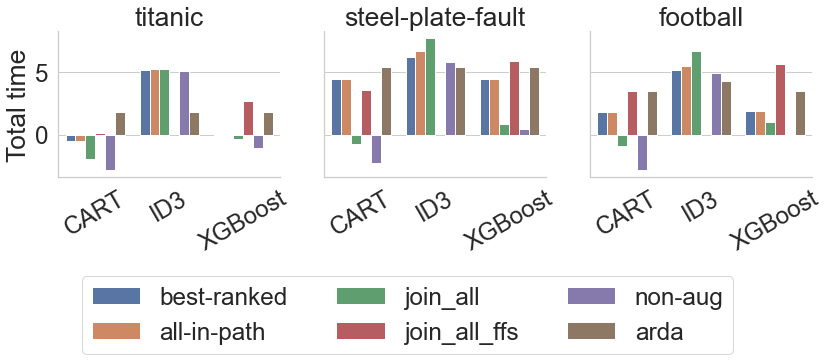

In [15]:
# Accuracy of BestRank, JoinAll and Non-Aug

from cmath import log
# display(train_time)

#### TOTAL TIME SMALL datasets
# label_order = {'best-ranked': 0, 'all-in-path': 1, 'join_all': 2}

total_time.sort_values(by=['algorithm'], ascending=True, inplace=True)
total_time_filtered = total_time[total_time['dataset'].isin(small_datasets)]
# total_time_filtered = total_time_filtered[total_time_filtered['approach'] != 'join_all']
total_time_filtered['total_time'] = total_time_filtered.apply(lambda row: log(row['total_time']), axis=1)
total_time_filtered.sort_values(by=['approach'], key=lambda x: x.map(label_order), inplace=True)


sns.set(font_scale=2.2, style="whitegrid")
colors = sns.color_palette("Set2")

g = sns.catplot(x="algorithm", y="total_time", hue="approach", col="dataset", data=total_time_filtered, kind="bar", height=4,
               order=algs)

g.set_titles("{col_name}")
g.set_xlabels('')
g.set_ylabels('Total time')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(0.7, -1.3), loc=4, ncol=3)

g.savefig('plots/total-time-all-small.png', dpi=300, bbox_inches="tight")

/var/folders/qt/6fl05zbd1qg522c_08dv10f40000gn/T/ipykernel_36572/1755753810.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_time_filtered['total_time'] = total_time_filtered.apply(lambda row: log(row['total_time']), axis=1)
/Users/andra/Developer/auto-data-augmentation/ada/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/Users/andra/Developer/auto-data-augmentation/ada/lib/python3.8/site-packages/matplotlib/transforms.py:774: ComplexWarning: Casting complex values to

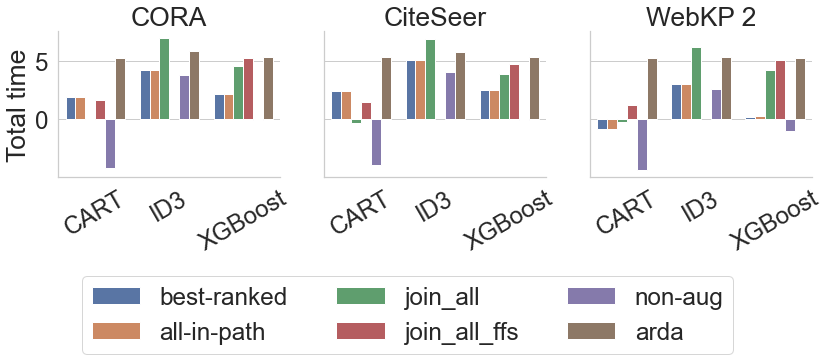

In [31]:
from cmath import log
# display(train_time)

#### TOTAL TIME BIG datasets
# label_order = {'best-ranked': 0, 'all-in-path': 1, 'join_all': 2}

total_time.sort_values(by=['algorithm'], ascending=True, inplace=True)
total_time_filtered = total_time[total_time['dataset'].isin(big_datasets)]
# total_time_filtered = total_time_filtered[total_time_filtered['approach'] != 'join_all']
total_time_filtered['total_time'] = total_time_filtered.apply(lambda row: log(row['total_time']), axis=1)
total_time_filtered.sort_values(by=['approach'], key=lambda x: x.map(label_order), inplace=True)


sns.set(font_scale=2.2, style="whitegrid")
colors = sns.color_palette("Set2")

g = sns.catplot(x="algorithm", y="total_time", hue="approach", col="dataset", data=total_time_filtered, kind="bar", height=4,
               order=algs)

g.set_titles("{col_name}")
g.set_xlabels('')
g.set_ylabels('Total time')

loc, labels = plt.xticks()
hh, ll = plt.gca().get_legend_handles_labels()

g.set_xticklabels(labels, rotation=30)
g._legend.remove()

plt.legend(hh, ll, bbox_to_anchor=(0.7, -1.3), loc=4, ncol=3)


g.savefig('plots/total-time-all-big.pdf', dpi=300, bbox_inches="tight")